In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from functions.general_functions import b_any_series, simulate_rectangular, simulate_randomfield, simulate_sinus, simulate_step, simulate_ramp
from functions.general_functions import ks_test_b_dist, inverse_norm, transform_n
from functions.eval_functions import pval_mac, mu_sigma_mac
from functions.one_dimensional import mac_one_dimension
from scipy.stats import norm

from seismostats import estimate_b, plot_cum_fmd, simulate_magnitudes_binned
%config InlineBackend.figure_format ='retina'

## Supplement: transformation of magnitudes

In [2]:
# generate synthetic magnitudes, b-value series and histograms
n_total = 50000
mc = 0
delta_m = 0.1
dates = np.arange(n_total)

# 1
n_m1 = 200
b = 1
mags1 = simulate_magnitudes_binned(n_total, b, mc, delta_m)
b_true1 = np.ones(len(mags1)) * b
b_time1, idx_max1, b_std1 = b_any_series(mags1, dates, n_m= n_m1, mc=mc, delta_m=delta_m, return_std=True, overlap=1, method='tinti')
b_all = estimate_b(mags1, mc, delta_m)

# 2 transform
n_m2 = 500
b_time2 = transform_n(b_time1, b_all,n_m1, n_m2)



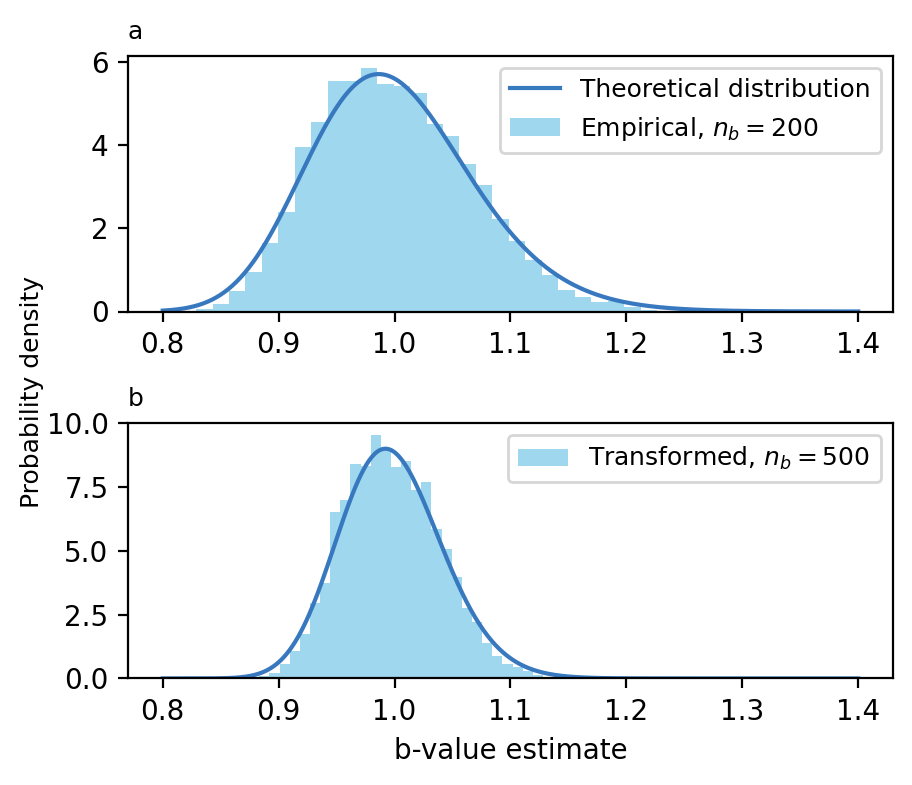

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(4.5, 4))

b_est = np.linspace(0.8, 1.4, 500)

# Create a figure
plt.rcParams.update({'font.size': 9})

ax[0].plot(b_est, inverse_norm(b_est, b_all, n_m1), color = '#3778bf', label='Theoretical distribution')
ax[0].hist(b_time1 , color='skyblue', density=True, label='Empirical, $n_b = 200$', alpha=0.8, bins=30)
ax[0].legend()
ax[0].set_title('a', fontsize=9, loc='left')

ax[1].plot(b_est,inverse_norm(b_est, b_all, n_m2), color = '#3778bf')
ax[1].hist(b_time2 , color='skyblue', density=True, label='Transformed, $n_b = 500$', alpha=0.8, bins=30)
ax[1].legend()
ax[1].set_title('b', fontsize=9, loc='left')

plt.xlabel('b-value estimate')

# put the y label in the middle of the two plots
fig.text(0, 0.5, 'Probability density', va='center', rotation='vertical')

plt.tight_layout()

# Figure 1: different underlying b-value variations

In [4]:
# generate synthetic b-value series

n_total = 50000
mc = 0
delta_m = 0.1
n_m = 500
dates = np.arange(n_total)

# 1 constant
b = 1
mags1 = simulate_magnitudes_binned(n_total, b, mc, delta_m)
b_true1 = np.ones(len(mags1)) * b
b_all1 = estimate_b(mags1, mc=mc, delta_m=delta_m)

# 2 rectangular
b = 0.98
n_anomal = 10000
delta_b = 0.1
mags2, b_true2 = simulate_rectangular(n_total, n_anomal, b, delta_b, mc, delta_m)
b_all2 = estimate_b(mags2, mc=mc, delta_m=delta_m)

# 3 ramp
b = 1.05
n_anomal = 4000
delta_b = -0.1
mags3, b_true3 = simulate_ramp(n_total, b, delta_b, mc, delta_m)
b_all3 = estimate_b(mags3, mc=mc, delta_m=delta_m)

# 4 sinusoidal
b = 1
n_anomal = 4000
delta_b = 0.05
mags4, b_true4 = simulate_sinus(n_total,n_anomal, b, delta_b, mc, delta_m)
b_all4 = estimate_b(mags4, mc=mc, delta_m=delta_m)

# 5 random field
b = 1
n_anomal = 1000
delta_b = 0.05
mags5, b_true5 = simulate_randomfield(n_total, n_anomal, b, delta_b, mc, delta_m)
b_all5 = estimate_b(mags5, mc=mc, delta_m=delta_m)


In [5]:
# KS test if the b-value estimates are distributed as expected (for constant b-value)
b_time, _, _ = b_any_series(mags1, dates, n_m = n_m, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='tinti')
ks_dist1, p_val_ks1, ks_dists1 = ks_test_b_dist(b_time, mc, delta_m, n_m, n=1000, b=b_all1)
print(p_val_ks1, 'constant')

b_time, _, _ = b_any_series(mags2, dates, n_m = n_m, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='tinti')
ks_dist2, p_val_ks2, ks_dists2 = ks_test_b_dist(b_time, mc, delta_m, n_m, n=1000, b=b_all2)
print(p_val_ks2, 'rectangular')

b_time, _, _ = b_any_series(mags3, dates, n_m = n_m, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='tinti')
ks_dist3, p_val_ks3, ks_dists3 = ks_test_b_dist(b_time, mc, delta_m, n_m, n=1000, b=b_all3)
print(p_val_ks3, 'ramp')

b_time, _, _ = b_any_series(mags4, dates, n_m = n_m, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='tinti')
ks_dist4, p_val_ks4, ks_dists4 = ks_test_b_dist(b_time, mc, delta_m, n_m, n=200, b=b_all4)
print(p_val_ks4, 'sinudoidal')

b_time, _, _ = b_any_series(mags5, dates, n_m = n_m, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='tinti')
ks_dist5, p_val_ks5, ks_dists5 = ks_test_b_dist(b_time, mc, delta_m, n_m, n=200, b=b_all5)
print(p_val_ks5, 'gaussian process')

0.834 constant
0.06 rectangular
0.474 ramp
0.19 sinudoidal
0.05 gaussian process


In [6]:
# Estimate mean autocorrelation and corresponding p-value
# another output is the 

times = np.arange(n_total)
n_points = len(times)/n_m

mac1, mu_mac1, std_mac1, b_time11, b_std11 = mac_one_dimension(times, mags1, delta_m, mc, times, n_points=n_points, n_realizations=1000, b_method='tinti', partitioning='constant_idx', image_tech='right')
p_val_MAC1 = 1 - norm(loc=mu_mac1, scale=std_mac1).cdf(mac1)

mac2, mu_mac2, std_mac2, b_time22, b_std22 = mac_one_dimension(times, mags2, delta_m, mc, times, n_points=n_points, n_realizations=1000, b_method='tinti', partitioning='constant_idx', image_tech='right')
p_val_MAC2 = 1 - norm(loc=mu_mac2, scale=std_mac2).cdf(mac2)

mac3, mu_mac3, std_mac3, b_time33, b_std33 = mac_one_dimension(times, mags3, delta_m, mc, times, n_points=n_points, n_realizations=1000, b_method='tinti', partitioning='constant_idx', image_tech='right')
p_val_MAC3 = 1 - norm(loc=mu_mac3, scale=std_mac3).cdf(mac3)

mac4, mu_mac4, std_mac4, b_time44, b_std44 = mac_one_dimension(times, mags4, delta_m, mc, times, n_points=n_points, n_realizations=1000, b_method='tinti', partitioning='constant_idx', image_tech='right')
p_val_MAC4 = 1 - norm(loc=mu_mac4, scale=std_mac4).cdf(mac4)

mac5, mu_mac5, std_mac5,b_time55, b_std55 = mac_one_dimension(times, mags5, delta_m, mc, times, n_points=n_points, n_realizations=1000, b_method='tinti', partitioning='constant_idx', image_tech='right')
p_val_MAC5 = 1 - norm(loc=mu_mac5, scale=std_mac5).cdf(mac5)

/Users/aron/polybox/Projects/b_significant/functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"


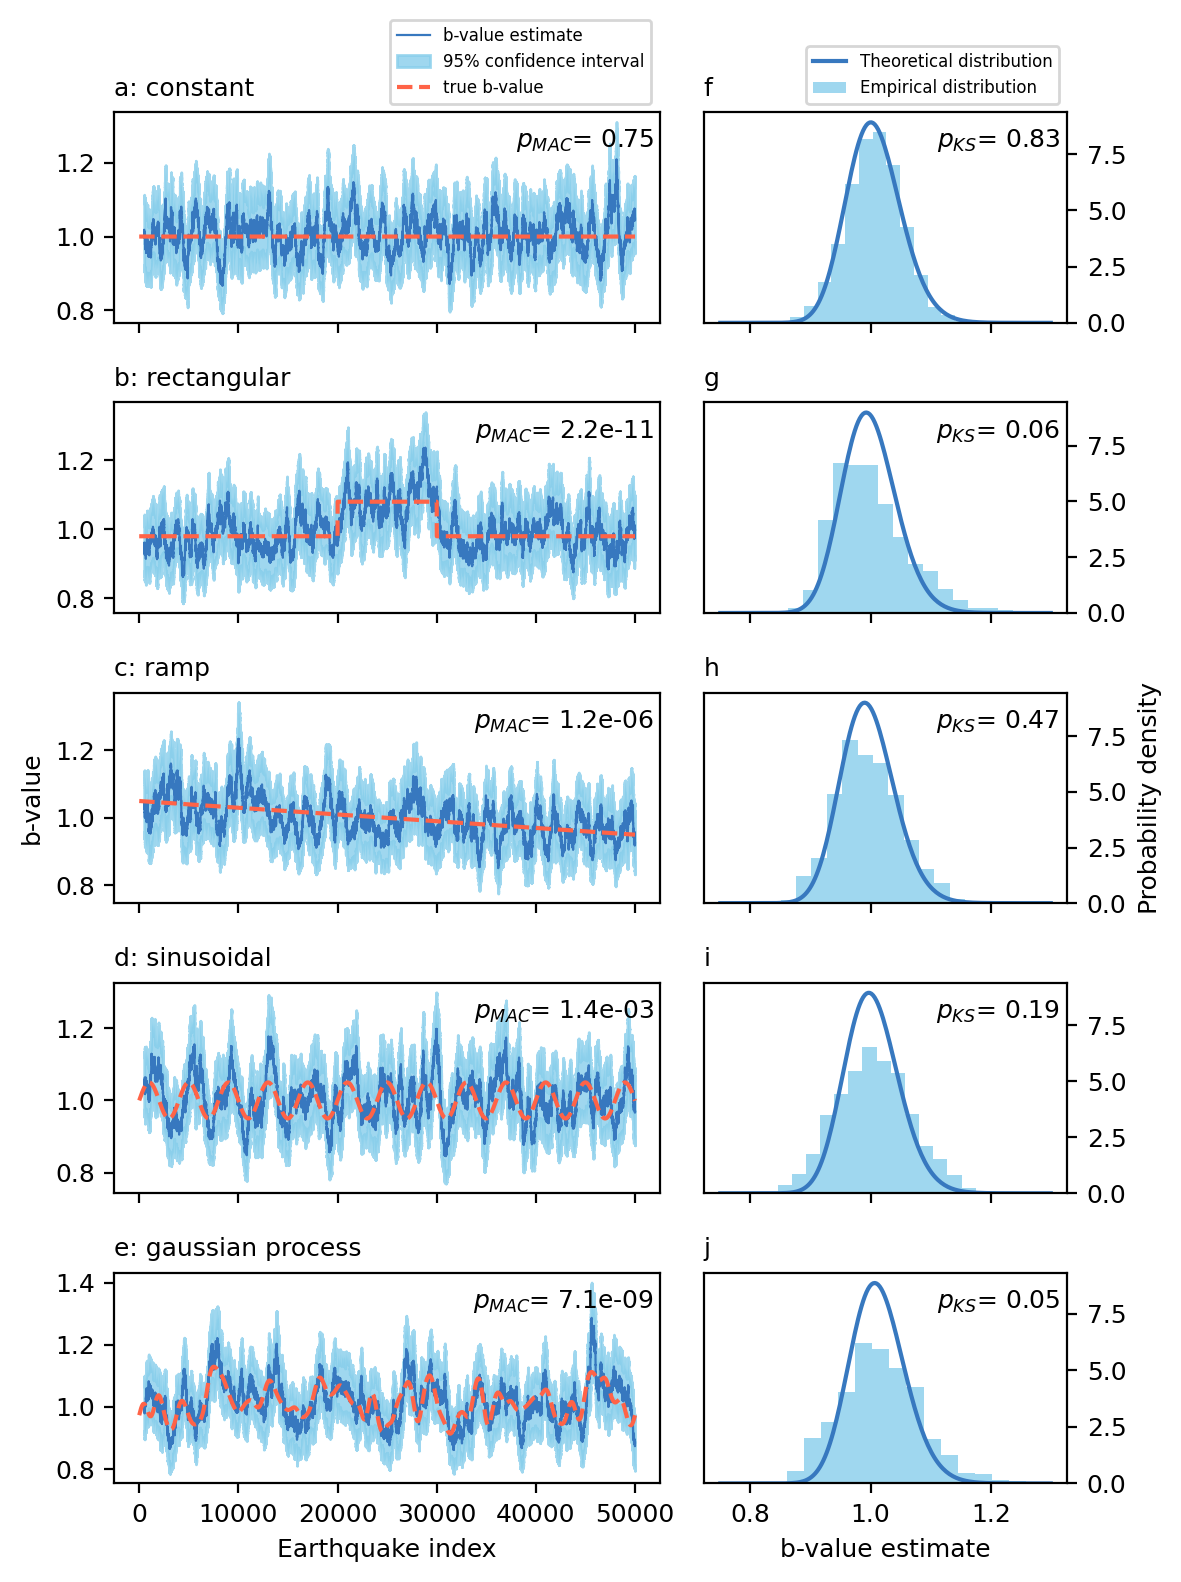

In [10]:
b_est = np.linspace(0.75, 1.3, 200)

# Create a figure
fig, axs = plt.subplots(5, 2, figsize=(6, 8), gridspec_kw={'width_ratios': [1.5, 1]})
plt.rcParams.update({'font.size': 9})

# 1
idx = b_time11 > 0
b_temp = b_time11[idx]
std_temp = b_std11[idx]
dates_temp = dates[idx]
axs[0, 0].plot(dates_temp, b_temp, label='b-value estimate', color='#3778bf', linewidth=0.8)
axs[0, 0].fill_between(dates_temp, b_temp-1.96*std_temp, b_temp+1.96*std_temp, alpha=0.8, label='95% confidence interval', color='skyblue')
axs[0, 0].plot(dates, b_true1, color='tomato', linestyle='--', label='true b-value', linewidth=1.5)
axs[0, 0].legend(bbox_to_anchor=(1, 1), loc="lower right", fontsize=6)
axs[0, 0].set_title('a: constant', fontsize=9, loc='left')
axs[0, 0].text(0.99, 0.8, '$p_{MAC}$'+ '= {:.2f}'.format(p_val_MAC1), transform=axs[0, 0].transAxes, ha='right', va='bottom')
axs[0, 0].set_xticklabels([])


axs[0, 1].plot(b_est, inverse_norm(b_est, b_all1, n_m), color = '#3778bf', label='Theoretical distribution')
axs[0, 1].hist(b_temp , color='skyblue', density=True, label='Empirical distribution', alpha=0.8, bins=15)
axs[0, 1].legend(bbox_to_anchor=(1, 1), loc="lower right", fontsize=6)
axs[0, 1].set_title('f', fontsize=9, loc='left')
axs[0, 1].text(0.98, 0.8, '$p_{KS}$' + '= {:.2f}'.format(p_val_ks1), transform=axs[0, 1].transAxes, ha='right', va='bottom')
axs[0, 1].yaxis.tick_right() 
axs[0, 1].set_xticklabels([])

# 2
idx = b_time22 > 0
b_temp = b_time22[idx]
std_temp = b_std22[idx]
dates_temp = dates[idx]
axs[1, 0].plot(dates_temp, b_temp, label='b-value estimate', color='#3778bf', linewidth=0.8)
axs[1, 0].fill_between(dates_temp, b_temp-1.96*std_temp, b_temp+1.96*std_temp, alpha=0.8, label='95% confidence interval', color='skyblue')
axs[1, 0].plot(dates, b_true2, color='tomato', linestyle='--', label='true b-value', linewidth=1.5)
axs[1, 0].set_title('b: rectangular', fontsize=9, loc='left')
axs[1, 0].text(0.99, 0.8, '$p_{MAC}$'+ '= {:.1e}'.format(p_val_MAC2), transform=axs[1, 0].transAxes, ha='right', va='bottom')
axs[1, 0].set_xticklabels([])


axs[1, 1].plot(b_est, inverse_norm(b_est, b_all2, n_m), color = '#3778bf', label='Theoretical distribution')
axs[1, 1].hist(b_temp , color='skyblue', density=True, label='Empirical distribution', alpha=0.8, bins=15)
axs[1, 1].yaxis. tick_right() 
axs[1, 1].set_title('g', fontsize=9, loc='left')
axs[1, 1].text(0.98, 0.8, '$p_{KS}$' + '= {:.2f}'.format(p_val_ks2), transform=axs[1, 1].transAxes, ha='right', va='bottom')
axs[1, 1].set_xticklabels([])

# 3
idx = b_time33 > 0
b_temp = b_time33[idx]
std_temp = b_std33[idx]
dates_temp = dates[idx]
axs[2, 0].plot(dates_temp, b_temp, label='b-value estimate', color='#3778bf', linewidth=0.8)
axs[2, 0].fill_between(dates_temp, b_temp-1.96*std_temp, b_temp+1.96*std_temp, alpha=0.8, label='95% confidence interval', color='skyblue')
axs[2, 0].plot(dates, b_true3, color='tomato', linestyle='--', label='true b-value', linewidth=1.5)
axs[2, 0].set_title('c: ramp', fontsize=9, loc='left')
axs[2, 0].text(0.99, 0.8, '$p_{MAC}$'+ '= {:.1e}'.format(p_val_MAC3), transform=axs[2, 0].transAxes, ha='right', va='bottom')
axs[2, 0].set_xticklabels([])
axs[2, 0].set_ylabel('b-value')

axs[2, 1].plot(b_est, inverse_norm(b_est, b_all3, n_m), color = '#3778bf', label='Theoretical distribution')
axs[2, 1].hist(b_temp, color='skyblue', density=True, label='Empirical distribution', alpha=0.8, bins=15)
axs[2, 1].set_title('h', fontsize=9, loc='left')
axs[2, 1].text(0.98, 0.8, '$p_{KS}$' + '= {:.2f}'.format(p_val_ks3), transform=axs[2, 1].transAxes, ha='right', va='bottom')
axs[2, 1].yaxis. tick_right() 
axs[2, 1].set_xticklabels([])
axs[2, 1].yaxis.set_label_position("right")
axs[2, 1].set_ylabel('Probability density')

# 4
idx = b_time44 > 0
b_temp = b_time44[idx]
std_temp = b_std44[idx]
dates_temp = dates[idx]
axs[3, 0].plot(dates_temp, b_temp, label='b-value estimate', color='#3778bf', linewidth=0.8)
axs[3, 0].fill_between(dates_temp, b_temp-1.96*std_temp, b_temp+1.96*std_temp, alpha=0.8, label='95% confidence interval', color='skyblue')
axs[3, 0].plot(dates, b_true4, color='tomato', linestyle='--', label='true b-value', linewidth=1.5)
axs[3, 0].set_title('d: sinusoidal', fontsize=9, loc='left')
axs[3, 0].text(0.99, 0.8, '$p_{MAC}$'+ '= {:.1e}'.format(p_val_MAC4), transform=axs[3, 0].transAxes, ha='right', va='bottom')
axs[3, 0].set_xticklabels([])

axs[3, 1].plot(b_est, inverse_norm(b_est, b_all4, n_m), color = '#3778bf', label='Theoretical distribution')
axs[3, 1].hist(b_temp, color='skyblue', density=True, label='Empirical distribution', alpha=0.8, bins=15)
axs[3, 1].set_title('i', fontsize=9, loc='left')
axs[3, 1].text(0.98, 0.8, '$p_{KS}$' + '= {:.2f}'.format(p_val_ks4), transform=axs[3, 1].transAxes, ha='right', va='bottom')
axs[3, 1].yaxis.tick_right() 
axs[3, 1].set_xticklabels([])

# 5
idx = b_time55 > 0
b_temp = b_time55[idx]
std_temp = b_std55[idx]
dates_temp = dates[idx]
axs[4, 0].plot(dates_temp, b_temp, label='b-value estimate', color='#3778bf', linewidth=0.8)
axs[4, 0].fill_between(dates_temp, b_temp-1.96*std_temp, b_temp+1.96*std_temp, alpha=0.8, label='95% confidence interval', color='skyblue')
axs[4, 0].plot(dates, b_true5, color='tomato', linestyle='--', label='true b-value', linewidth=1.5)
axs[4, 0].set_xlabel('Earthquake index')
axs[4, 0].set_title('e: gaussian process', fontsize=9, loc='left')
axs[4, 0].text(0.99, 0.8, '$p_{MAC}$'+ '= {:.1e}'.format(p_val_MAC5), transform=axs[4, 0].transAxes, ha='right', va='bottom')

axs[4, 1].plot(b_est, inverse_norm(b_est, b_all5, n_m), color = '#3778bf', label='Theoretical distribution')
axs[4, 1].hist(b_temp, color='skyblue', density=True, label='Empirical distribution', alpha=0.8, bins=15)
axs[4, 1].set_xlabel('b-value estimate')
axs[4, 1].set_title('j', fontsize=9, loc='left')
axs[4, 1].text(0.98, 0.8, '$p_{KS}$' + '= {:.2f}'.format(p_val_ks5), transform=axs[4, 1].transAxes, ha='right', va='bottom')
axs[4, 1].yaxis.tick_right() 
plt.tight_layout()


# Figure 3: Length scale and information gain, one example and two synthetic tests

In [5]:
def get_MAC_vs_npoints_1D(
      order,
      cut_mags,
      delta_m,
      mc,
      cut_times,
      n_points,
      n=200,
      b_method="positive",
      partitioning = 'constant_idx',
      image_tech = 'right',
      scaling_factor=1):

      idx_order = np.argsort(order)
      order = order[idx_order]
      cut_mags = cut_mags[idx_order]
      cut_times = cut_times[idx_order]

      # estimate MAC for different number of points
      mac = np.zeros(len(n_points))
      mu_mac = np.zeros(len(n_points))
      std_mac = np.zeros(len(n_points))
      b_average= []
      std_b =[]
      n_m = np.zeros(len(n_points))
      a_average = []
      for ii, n_point in enumerate(tqdm(n_points, desc="Processing")):
         (mac[ii], mu_mac[ii], std_mac[ii], b_average_loop, std_b_loop, n_m[ii]
          ) = mac_one_dimension(order, cut_mags, delta_m, mc, cut_times, n_points=n_point, n_realizations=n, b_method=b_method, partitioning=partitioning, image_tech=image_tech, scaling_factor=scaling_factor, return_nm=True)
         b_average.append(b_average_loop)
         std_b.append(std_b_loop)

      return mac, mu_mac, std_mac, b_average, std_b, n_m

In [6]:
n_ms = np.arange(25, 2000, 50)
n_points = np.round(len(mags5)/ n_ms)
n_points = np.unique(n_points).astype(int)

mac5, mu_mac5, std_mac5, _, _, n_ms = get_MAC_vs_npoints_1D(dates, mags5, delta_m, mc, dates, n_points, n=2000, b_method = 'tinti', partitioning = 'constant_idx', image_tech='center')

Processing:   3%|▎         | 1/39 [00:02<01:53,  2.98s/it]/Users/aron/polybox/Projects/b_significant/functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"
Processing:  97%|█████████▋| 38/39 [01:23<00:01,  1.52s/it]/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(
Processing: 100%|██████████| 39/39 [01:24<00:00,  2.17s/it]


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_64362/3770625411.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_ms, mu_mac5, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


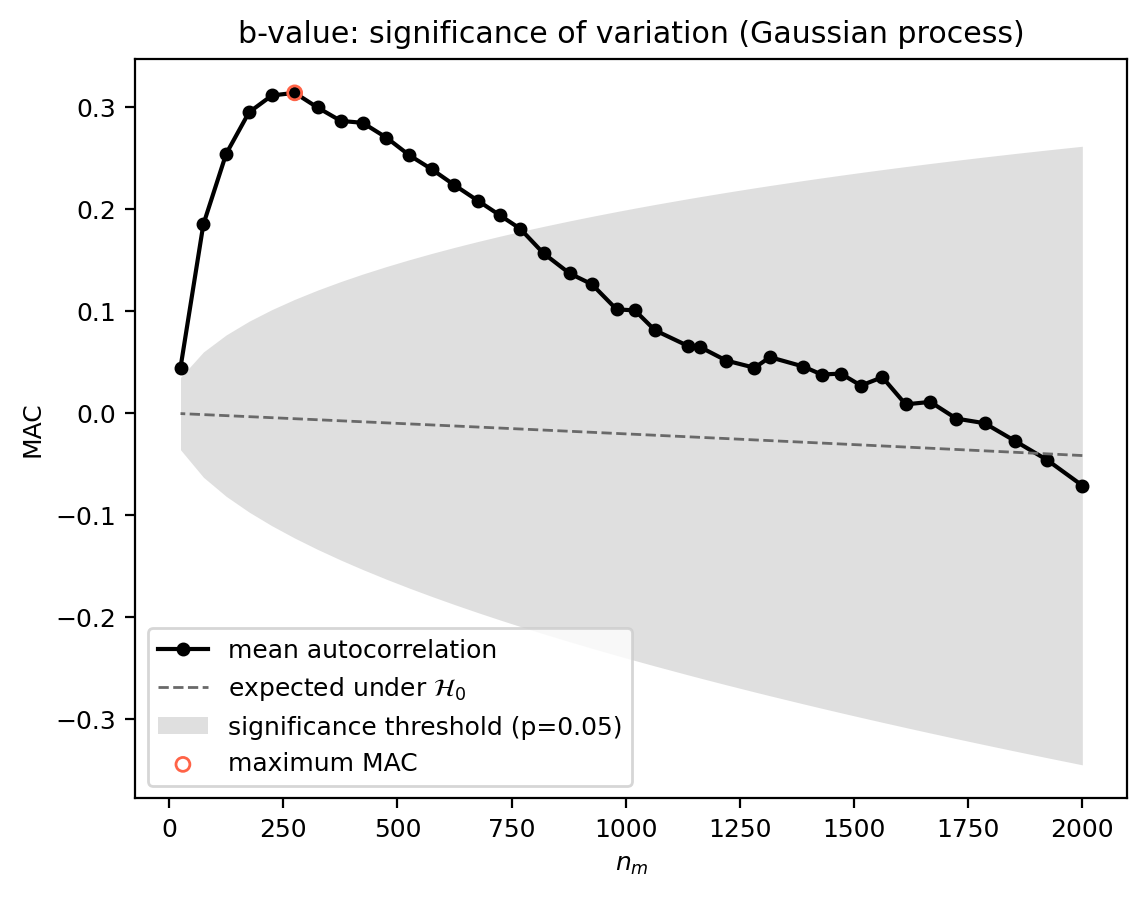

In [7]:
ax = plt.subplots()[1]

ax.plot(n_ms, mac5, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_ms, mu_mac5, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_ms, mu_mac5 - 1.96 * std_mac5, mu_mac5 + 1.96 * std_mac5, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

n_max = np.argmax(mac5)
plt.scatter(n_ms[n_max], mac5[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('b-value: significance of variation (Gaussian process)')

In [8]:
mac1, mu_mac1, std_mac1, _, _, _ = get_MAC_vs_npoints_1D(dates, mags1, delta_m, mc, dates, n_points, n=2000, b_method = 'tinti', partitioning = 'constant_idx', image_tech='center')

Processing:   3%|▎         | 1/39 [00:02<01:52,  2.95s/it]/Users/aron/polybox/Projects/b_significant/functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"
Processing:  97%|█████████▋| 38/39 [01:24<00:01,  1.52s/it]/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(
Processing: 100%|██████████| 39/39 [01:25<00:00,  2.20s/it]


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_64362/206514098.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_ms, mu_mac1, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


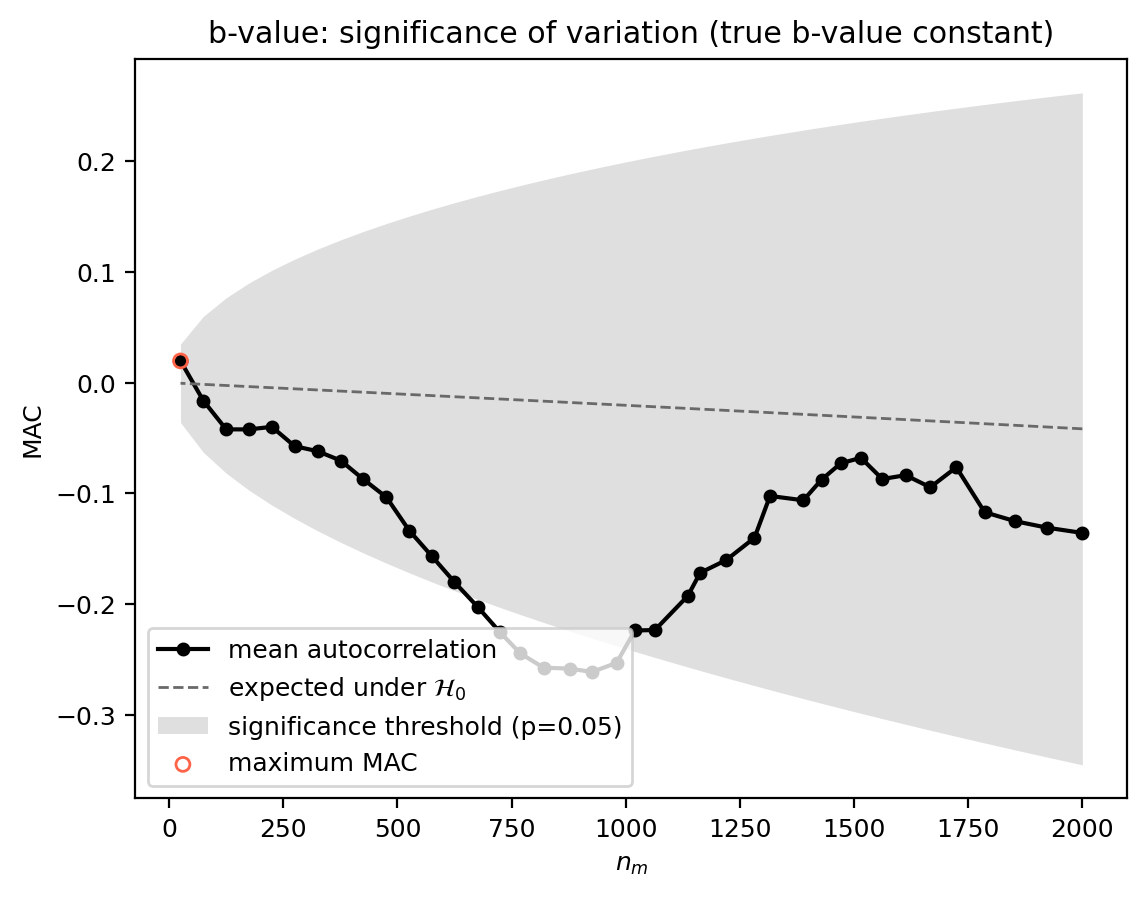

In [9]:
ax = plt.subplots()[1]

ax.plot(n_ms, mac1, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_ms, mu_mac1, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_ms, mu_mac1 - 1.96 * std_mac1, mu_mac1 + 1.96 * std_mac1, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

n_max = np.argmax(mac1)
plt.scatter(n_ms[n_max], mac1[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('b-value: significance of variation (true b-value constant)')

In [10]:
mac4, mu_mac4, std_mac4, _, _, _ = get_MAC_vs_npoints_1D(dates, mags4, delta_m, mc, dates, n_points, n=2000, b_method = 'tinti', partitioning = 'constant_idx', image_tech='center')

Processing:   3%|▎         | 1/39 [00:02<01:51,  2.93s/it]/Users/aron/polybox/Projects/b_significant/functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"
Processing:  97%|█████████▋| 38/39 [01:23<00:01,  1.51s/it]/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(
Processing: 100%|██████████| 39/39 [01:25<00:00,  2.18s/it]


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_64362/940534482.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_ms, mu_mac4, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


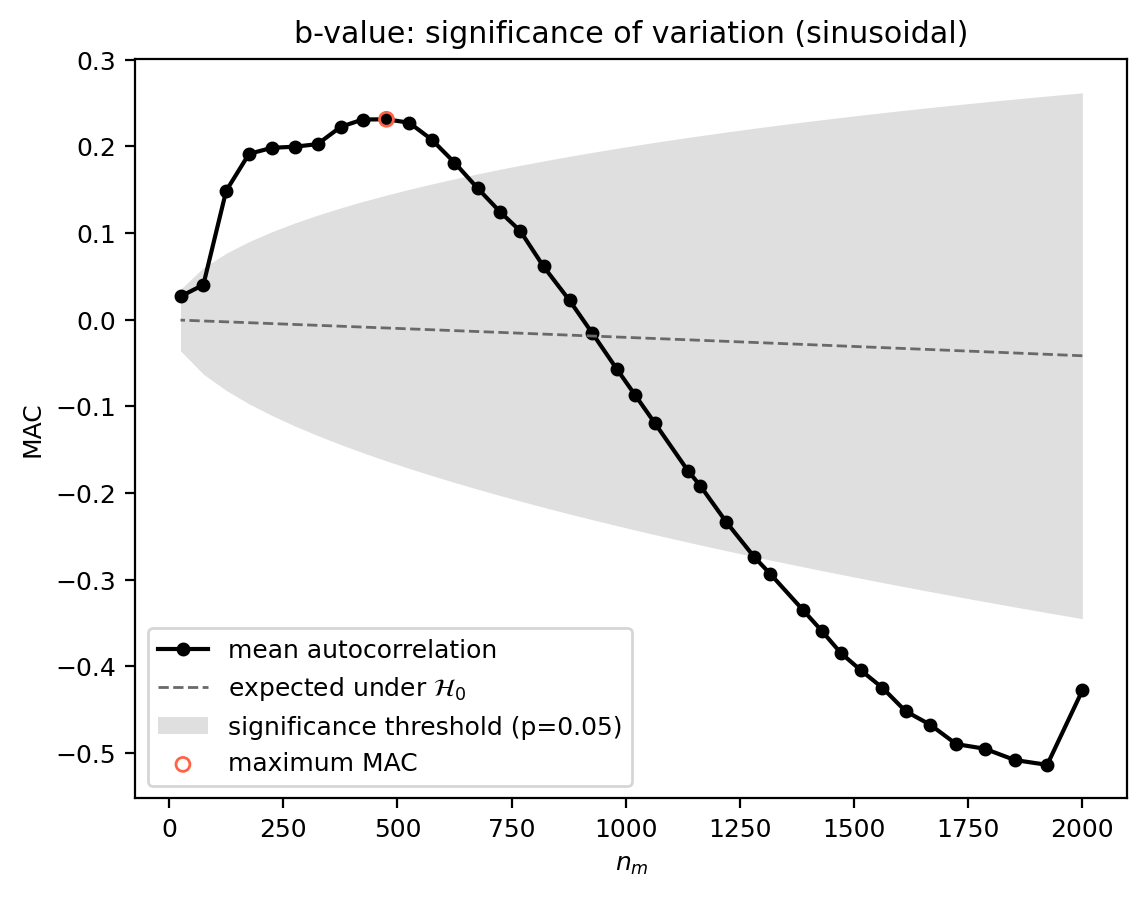

In [11]:
ax = plt.subplots()[1]

ax.plot(n_ms, mac4, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_ms, mu_mac4, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_ms, mu_mac4 - 1.96 * std_mac4, mu_mac4 + 1.96 * std_mac4, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

n_max = np.argmax(mac4)
plt.scatter(n_ms[n_max], mac4[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('b-value: significance of variation (sinusoidal)')

450.0
375.0
525.0


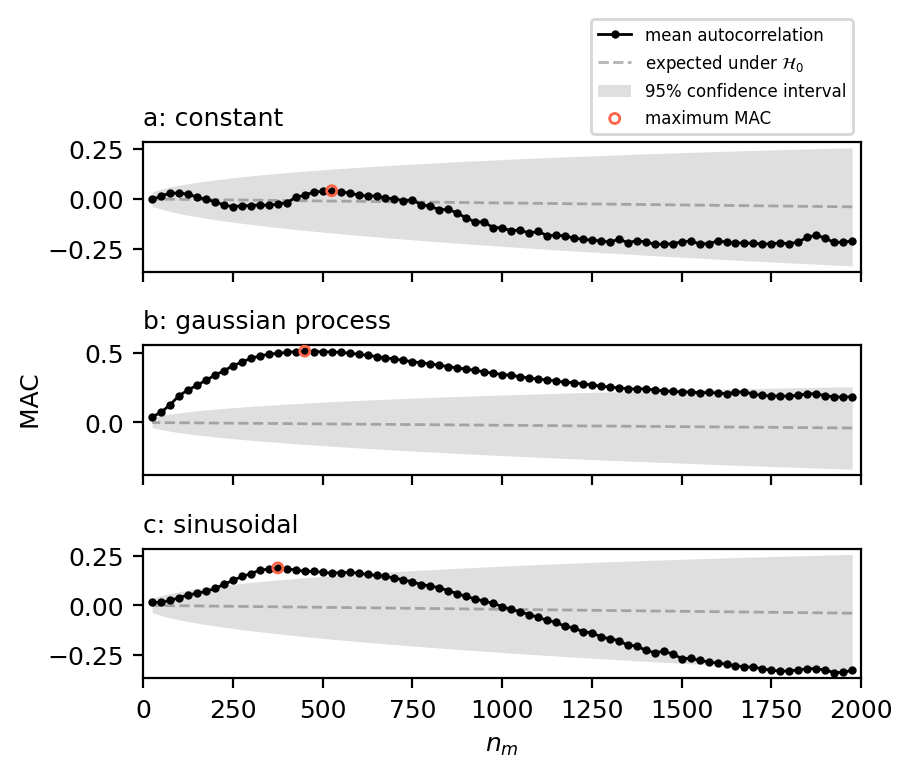

In [84]:
cutting = 'constant_idx'
n_total = 50000

# Create a figure
fig, axs = plt.subplots(3, 1, figsize=(4.5, 4))
plt.rcParams.update({'font.size': 9})

# 1
axs[1].plot(n_ms, mac1, color='k', label='mean autocorrelation$', zorder=3, lw=1, marker='o', markersize=2)    
# Plot 0.05 threshold
axs[1].plot(n_ms, mu_mac1, color="dimgrey", linestyle="--", alpha=0.5, label="expected under $\mathcal{H}_0$", zorder=2, lw=1)
axs[1].fill_between(
    n_ms,
    1.96 * std_mac1 - mu_mac1,
    -1.96 * mu_mac1 - mu_mac1,
    color="silver",
    alpha=0.5,
    label="95% confidence interval",
    zorder=1,
    lw=0,
)
idx_max = np.argmax(acfs5)
print(n_bs5[idx_max])
axs[1].scatter(n_bs5[idx_max],acfs5[idx_max], label='maximum MAC', s=13, zorder=100, facecolor='none', edgecolor='tomato')

axs[1].set_title('b: gaussian process', fontsize=9, loc='left')
# limit
axs[1].set_xlim([0, 2000])
axs[1].set_xticklabels([])


# 2
axs[2].plot(n_bs4, acfs4, color='k', label='mean autocorrelation', zorder=3, lw=1, marker='o', markersize=2)    
# Plot 0.05 threshold
x = np.arange(n_total/max(n_bs4), n_total/min(n_bs4) + 1, 1)
mu, sigma = mu_sigma_mac(x, cutting)
axs[2].plot(n_total / x, mu, color="dimgrey", linestyle="--", alpha=0.5, label="expected under $\mathcal{H}_0$", zorder=2, lw=1)
axs[2].fill_between(
    n_total / x,
    1.96 * sigma - 1 / x,
    -1.96 * sigma - 1 / x,
    color="silver",
    alpha=0.5,
    label="95% confidence interval",
    zorder=1,
    lw=0,
)
idx_max = np.argmax(acfs4)
print(n_bs4[idx_max])
axs[2].scatter(n_bs4[idx_max],acfs4[idx_max], label='maximum MAC', s=13, zorder=100, facecolor='none', edgecolor='tomato')
axs[2].set_title('c: sinusoidal', fontsize=9, loc='left')
# limit
axs[2].set_xlim([0, 2000])

# 3
axs[0].plot(n_bs1, acfs1, color='k', label='mean autocorrelation', zorder=3, lw=1, marker='o', markersize=2)    
# Plot 0.05 threshold
x = np.arange(n_total/max(n_bs1), n_total/min(n_bs1) + 1, 1)
mu, sigma = mu_sigma_mac(x, cutting)
axs[0].plot(n_total / x, mu, color="dimgrey", linestyle="--", alpha=0.5, label="expected under $\mathcal{H}_0$", zorder=2, lw=1)
axs[0].fill_between(
    n_total / x,
    1.96 * sigma - 1 / x,
    -1.96 * sigma - 1 / x,
    color="silver",
    alpha=0.5,
    label="95% confidence interval",
    zorder=1,
    lw=0,
)
idx_max = np.argmax(acfs1)
print(n_bs1[idx_max])
axs[0].scatter(n_bs1[idx_max],acfs1[idx_max], label='maximum MAC', s=13, zorder=100, facecolor='none', edgecolor='tomato')
axs[0].set_xlim([0, 2000])
axs[0].legend(bbox_to_anchor=(1, 1), loc="lower right", fontsize=6)
axs[0].set_xticklabels([])
axs[0].set_title('a: constant', fontsize=9, loc='left')


# make title in the middle of both subfiugurs
fig.text(0, 0.5, 'MAC   ', va='center', rotation='vertical')
axs[2].set_xlabel('$n_m$')

plt.tight_layout()

In [5]:
diff_sum_here = []
diff_sum_next = []
diff_sum_nb = []
for n_b in n_bs:
    n_b = int(n_b)
    # measure how well the signal is reconstructed with the different n_bs
    b_time, idx_max, b_std = b_any_series(mags5, dates, n_b = n_b, mc=mc, delta_m=delta_m, return_std=True, overlap=0.9, method='tinti')
    b_all = estimate_b(mags5, mc, delta_m, method='tinti')

    # information gain (assuming that b_all = b)
    half = int(n_b/2)
    inf_gain_here = np.log(b_time/b_all) - (b_time-b_all)/b_true5[idx_max-half]
    diff_sum_here.append(sum(inf_gain_here)/len(inf_gain_here))

    idx_del = idx_max<len(b_true5)-1
    idx_max1 = idx_max[idx_del]
    inf_gain_next = np.log(b_time[idx_del]/b_all) - (b_time[idx_del]-b_all)/b_true5[idx_max1+1]
    diff_sum_next.append(sum(inf_gain_next)/len(inf_gain_next))
    
    idx_del = idx_max<len(b_true5)-n_b
    idx_max2 = idx_max[idx_del]
    inf_gain = np.zeros(len(b_time[idx_del]))
    for ii in range(1, n_b):
        inf_gain += np.log(b_time[idx_del]/b_all) - (b_time[idx_del]-b_all)/b_true5[idx_max2+ii]
    inf_gain = inf_gain/n_b
    diff_sum_nb.append(sum(inf_gain)/len(inf_gain))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


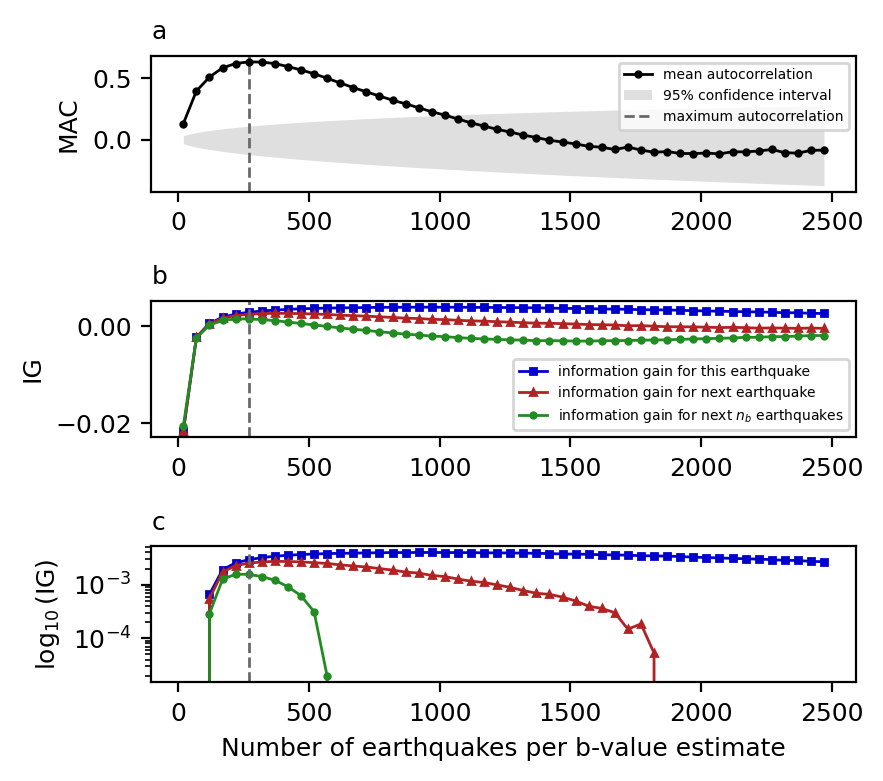

In [164]:
cutting = 'constant_idx'

# Create a figure
fig, axs = plt.subplots(3, 1, figsize=(4.5, 4))
plt.rcParams.update({'font.size': 9})

# 1
axs[0].plot(n_bs, acfs, color='k', label='mean autocorrelation', zorder=3, lw=1, marker='o', markersize=2)    
# Plot 0.05 threshold
x = np.arange(n_total/max(n_bs), n_total/min(n_bs) + 1, 1)
mu, sigma = mu_sigma_mac(x, cutting)
#axs[0].plot(n_total / x, mu, color="dimgrey", linestyle="--", alpha=0.5, label="expected MAC if b-value is constant", zorder=2, lw=1)
axs[0].fill_between(
    n_total / x,
    1.96 * sigma - 1 / x,
    -1.96 * sigma - 1 / x,
    color="silver",
    alpha=0.5,
    label="95% confidence interval",
    zorder=1,
    lw=0,
)
n_max = n_bs[np.argmax(acfs)]
axs[0].axvline(n_max, color='dimgrey', linestyle='--', label='maximum autocorrelation', lw=1)
axs[0].legend(loc="upper right", fontsize=5)
axs[0].set_title('a', fontsize=9, loc='left')
axs[0].set_ylabel('MAC')

axs[1].plot(n_bs, diff_sum_here, label='information gain for this earthquake', color='mediumblue', marker='s', markersize=2, lw=1)
axs[1].plot(n_bs, diff_sum_next, label='information gain for next earthquake', color='firebrick', marker='^', markersize=2, lw=1)
axs[1].plot(n_bs, diff_sum_nb, label='information gain for next $n_b$ earthquakes', color='forestgreen', marker='o', markersize=2, lw=1)
axs[1].axvline(n_max, color='dimgrey', linestyle='--', lw=1)
axs[1].legend(loc="lower right", fontsize=5)
axs[1].set_title('b', fontsize=9, loc='left')
axs[1].set_ylabel('IG')


axs[2].plot(n_bs, diff_sum_here, label='information gain for this earthquake', color='mediumblue', marker='s', markersize=2, lw=1)
axs[2].plot(n_bs, diff_sum_next, label='information gain for next earthquake', color='firebrick', marker='^', markersize=2, lw=1)
axs[2].plot(n_bs, diff_sum_nb, label='information gain for next $n_b$ arthquakes', color='forestgreen', marker='o', markersize=2, lw=1)
axs[2].axvline(n_max, color='dimgrey', linestyle='--', label='maximum autocorrelation', lw=1)
# logarithmic scale
axs[2].set_yscale('log')
axs[2].set_title('c', fontsize=9, loc='left')
axs[2].set_xlabel('Number of earthquakes per b-value estimate')
axs[2].set_ylabel('$\log_{10}$(IG)')

plt.tight_layout()

plt.savefig('../../Article_images/fig3.eps', format='eps')


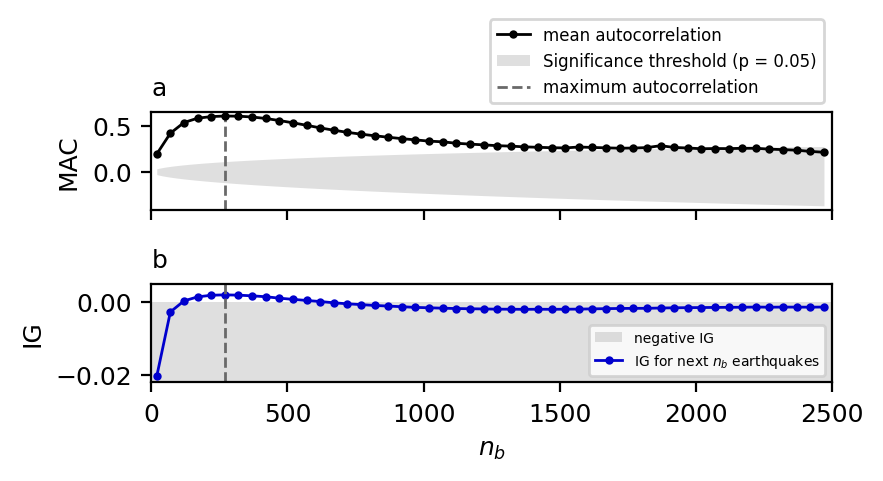

In [7]:
cutting = 'constant_idx'

# Create a figure
fig, axs = plt.subplots(2, 1, figsize=(4.5, 2.5))

plt.rcParams.update({'font.size': 9})

# 1
axs[0].plot(n_bs, acfs, color='k', label='mean autocorrelation', zorder=3, lw=1, marker='o', markersize=2)    
# Plot 0.05 threshold
x = np.arange(n_total/max(n_bs), n_total/min(n_bs) + 1, 1)
mu, sigma = mu_sigma_mac(x, cutting)
#axs[0].plot(n_total / x, mu, color="dimgrey", linestyle="--", alpha=0.5, label="expected MAC if b-value is constant", zorder=2, lw=1)
axs[0].fill_between(
    n_total / x,
    1.96 * sigma - 1 / x,
    -1.96 * sigma - 1 / x,
    color="silver",
    alpha=0.5,
    label="Significance threshold (p = 0.05)",
    zorder=1,
    lw=0,
)
n_max = n_bs[np.argmax(acfs)]
axs[0].axvline(n_max, color='dimgrey', linestyle='--', label='maximum autocorrelation', lw=1)

axs[0].legend(bbox_to_anchor=(1, 1), loc="lower right", fontsize=6)
axs[0].set_title('a', fontsize=9, loc='left')
axs[0].set_ylabel('MAC')
axs[0].set_xticklabels([])


axs[1].fill_between([-50,2600],
                    np.zeros(2),
                    np.zeros(2) - 0.024,
                    color="silver",
                    alpha=0.5,
                    label="negative IG",
                    zorder=1,
                    lw=0,
)
axs[1].plot(n_bs, diff_sum_nb, label='IG for next $n_b$ earthquakes', color='mediumblue', marker='o', markersize=2, lw=1)
axs[1].axvline(n_max, color='dimgrey', linestyle='--', lw=1)
axs[1].legend(loc="lower right", fontsize=5)
axs[1].set_title('b', fontsize=9, loc='left')
axs[1].set_ylabel('IG')

axs[1].set_xlim([0,2500])
axs[0].set_xlim([0,2500])
axs[1].set_ylim([-0.022,0.005])
axs[1].set_xlabel('$n_b$')

plt.tight_layout()

In [2]:
n = 50000
n_anomal = 1000
b = 1
delta_b = 0.07
mc = 0
delta_m = 0.1

mags, b_true = simulate_randomfield(n, n_anomal, b, delta_b, mc, delta_m)
#mags, b_true = simulate_rectangular(n, n_anomal, b, delta_b, mc, delta_m)
#mags, b_true = simulate_sinus(n, n_anomal, b, delta_b, mc, delta_m)
#mags, b_true = simulate_ramp(n, b, delta_b, mc, delta_m)
#mags, b_true = simulate_step(n, b, delta_b, mc, delta_m)

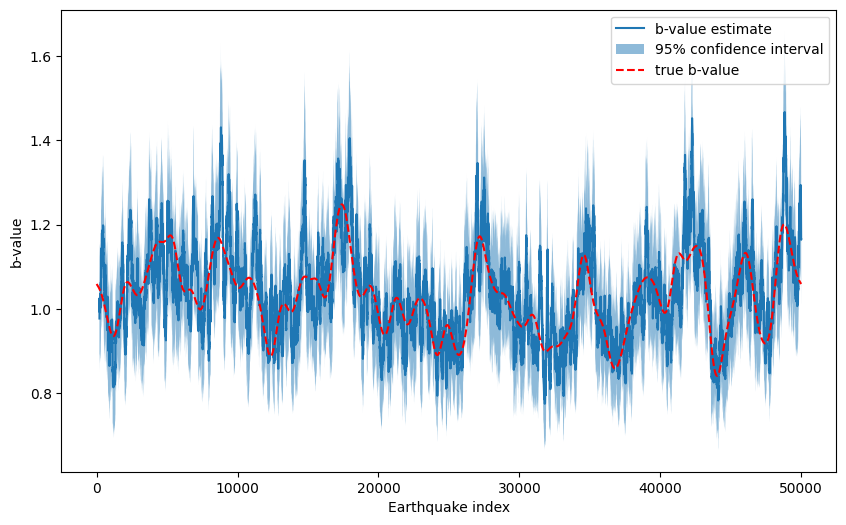

In [3]:
dates = np.arange(len(mags))
b_time, idx_max, b_std = b_any_series(mags, dates, n_b = 200, mc=mc, delta_m=delta_m, return_std=True, overlap=1, method='tinti')

# plot nicely
ax = plt.subplots(figsize=(10,6))[1]
ax.plot(dates[idx_max], b_time, label='b-value estimate')
ax.fill_between(dates[idx_max], b_time-1.96*b_std, b_time+1.96*b_std, alpha=0.5, label='95% confidence interval')
ax.plot(dates, b_true, color='red', linestyle='--', label='true b-value')
b_all = estimate_b(mags, mc=mc, delta_m=delta_m)
#ax.axhline(b_all, color='gray', linestyle='--')
ax.set_xlabel('Earthquake index')
ax.set_ylabel('b-value')
ax.legend()

In [4]:
b_all

1.0222051816735929

<Axes: xlabel='Magnitude', ylabel='N'>

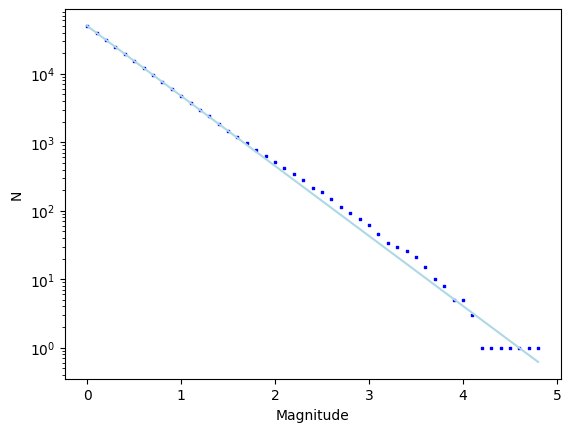

In [5]:
plot_cum_fmd(mags,b_value=b_all ,delta_m=delta_m, color=['blue','lightblue'])

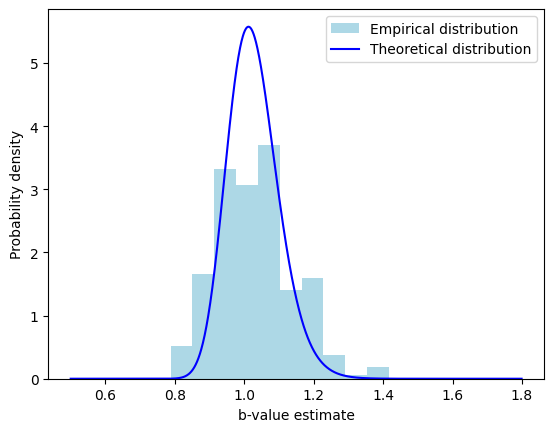

In [6]:
b_time, idx_max, b_std = b_any_series(mags, dates, n_b = 200, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='tinti')

plt.hist(b_time , color='lightblue', density=True, label='Empirical distribution')

b_est = np.arange(0.5,1.8,0.001)
plt.plot(b_est, inverse_norm(b_est, b_all, 200), color = 'blue', label='Theoretical distribution')

plt.xlabel('b-value estimate')
plt.ylabel('Probability density')
plt.legend()

# Figure 1

In [5]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from functions.general_functions import b_any_series
from seismostats import bin_to_precision, estimate_b, plot_fmd, plot_mags_in_time, plot_cum_fmd
from seismostats.io.client import FDSNWSEventClient

In [48]:
start_time = pd.to_datetime('2016/01/01')
end_time = dt.datetime.now()

min_magnitude = 4
url = 'http://service.iris.edu/fdsnws/event/1/query'
client_iris = FDSNWSEventClient(url)
df = client_iris.get_events(
        start_time=start_time,
        end_time=end_time,
        min_magnitude=min_magnitude,
)

In [69]:
# load dataframe from textfile
df_raw = pd.read_csv('data/world_76_globalcmt.csv')

In [85]:
# empty dataframe
df = pd.DataFrame()

# mags
df['magnitude'] = df_raw['magnitude']

# lon
df['longitude'] = df_raw['longitude']
# lat
df['latitude'] = df_raw['latitude']
# depth
df['depth'] = df_raw['depth']
# time
df['time'] = pd.to_datetime(df_raw['date'] + ' ' + [a[:-5] for a in df_raw['time']])

/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_35721/3260189916.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df_raw['date'] + ' ' + [a[:-5] for a in df_raw['time']])


In [106]:
df

magnitude  longitude  latitude  depth                time
0            6.2    -177.64    -28.61   59.0 1976-01-01 01:29:00
1            6.0     -74.90    -13.29   95.0 1976-05-01 02:31:00
2            5.7     159.33     51.60   33.0 1976-06-01 21:08:00
3            6.1     167.87    -15.76  168.0 1976-09-01 23:54:00
4            6.0     -16.58     66.16   33.0 1976-01-13 13:29:00
...          ...        ...       ...    ...                 ...
56827        0.0     127.49     -2.40   16.4 2020-12-30 19:10:00
56828        0.0     -13.66     -1.25   10.0 2020-12-30 21:58:00
56829        0.0     122.28     -8.74  130.1 2020-12-31 10:18:00
56830        0.0     146.84     -0.80   10.0 2020-12-31 19:50:00
56831        0.0     118.92     -9.11   85.7 2020-12-31 23:12:00

[56832 rows x 5 columns]

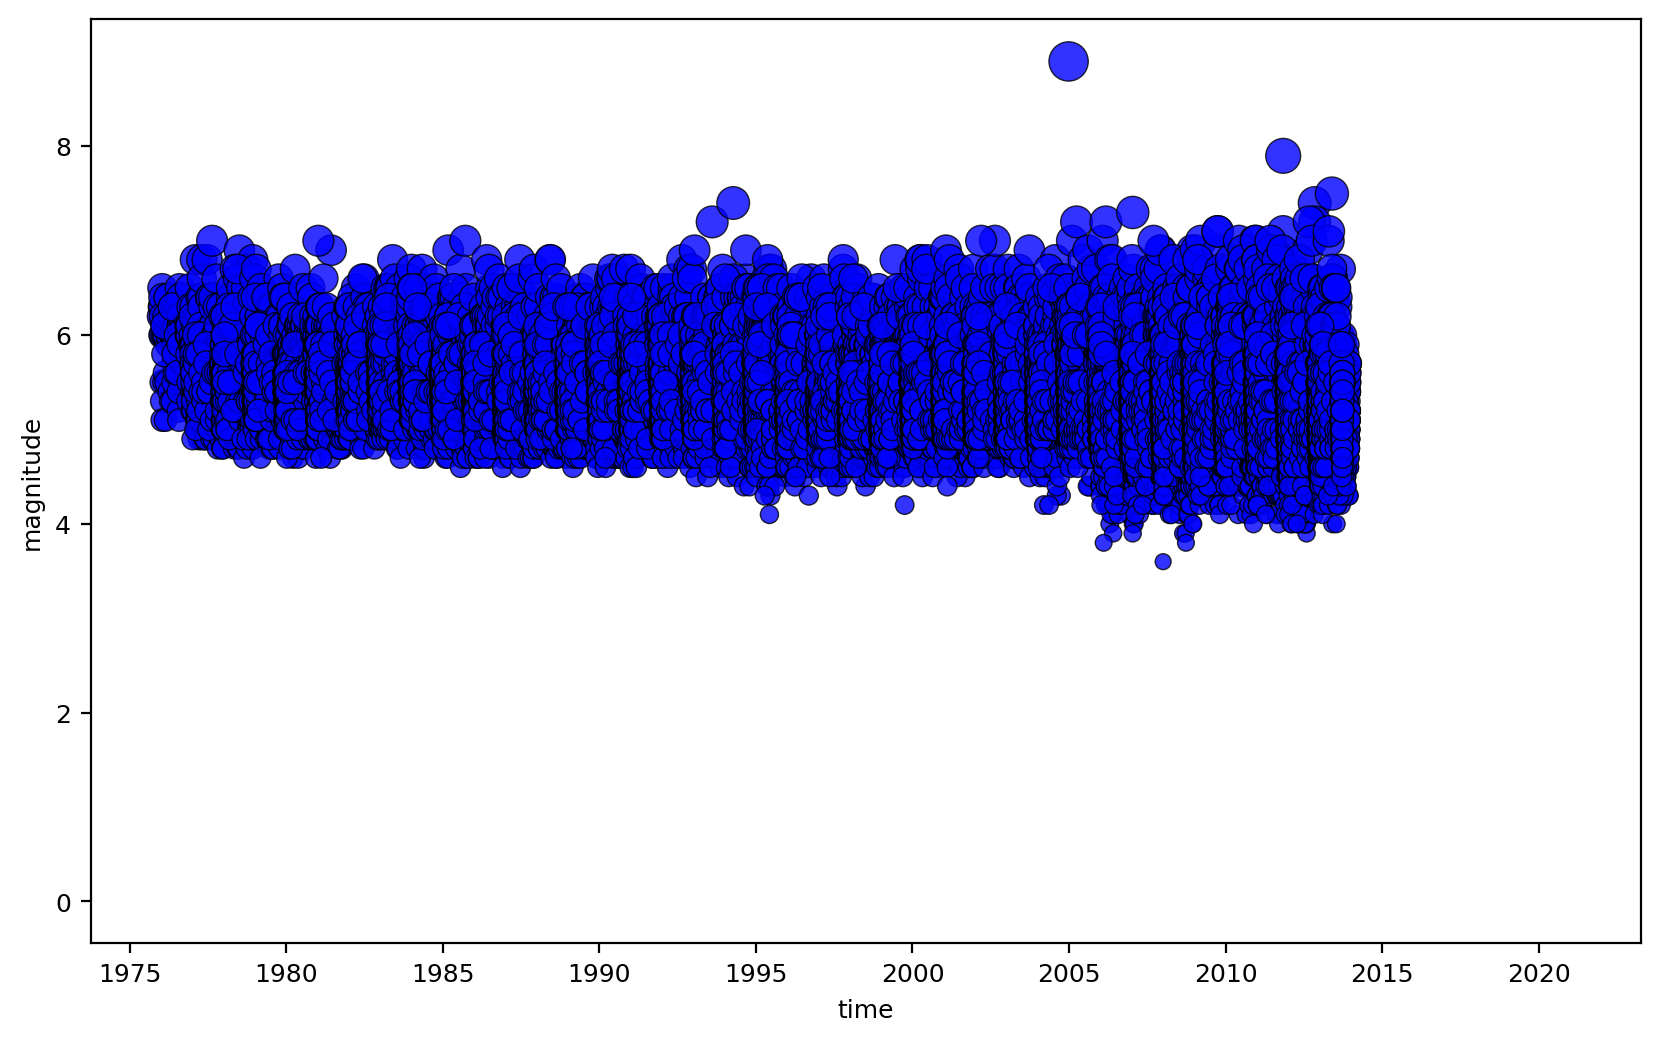

In [118]:
ax = plt.subplots(figsize=(10, 6))[1]
ax = plot_mags_in_time(df, ax=ax, dot_smallest=0)

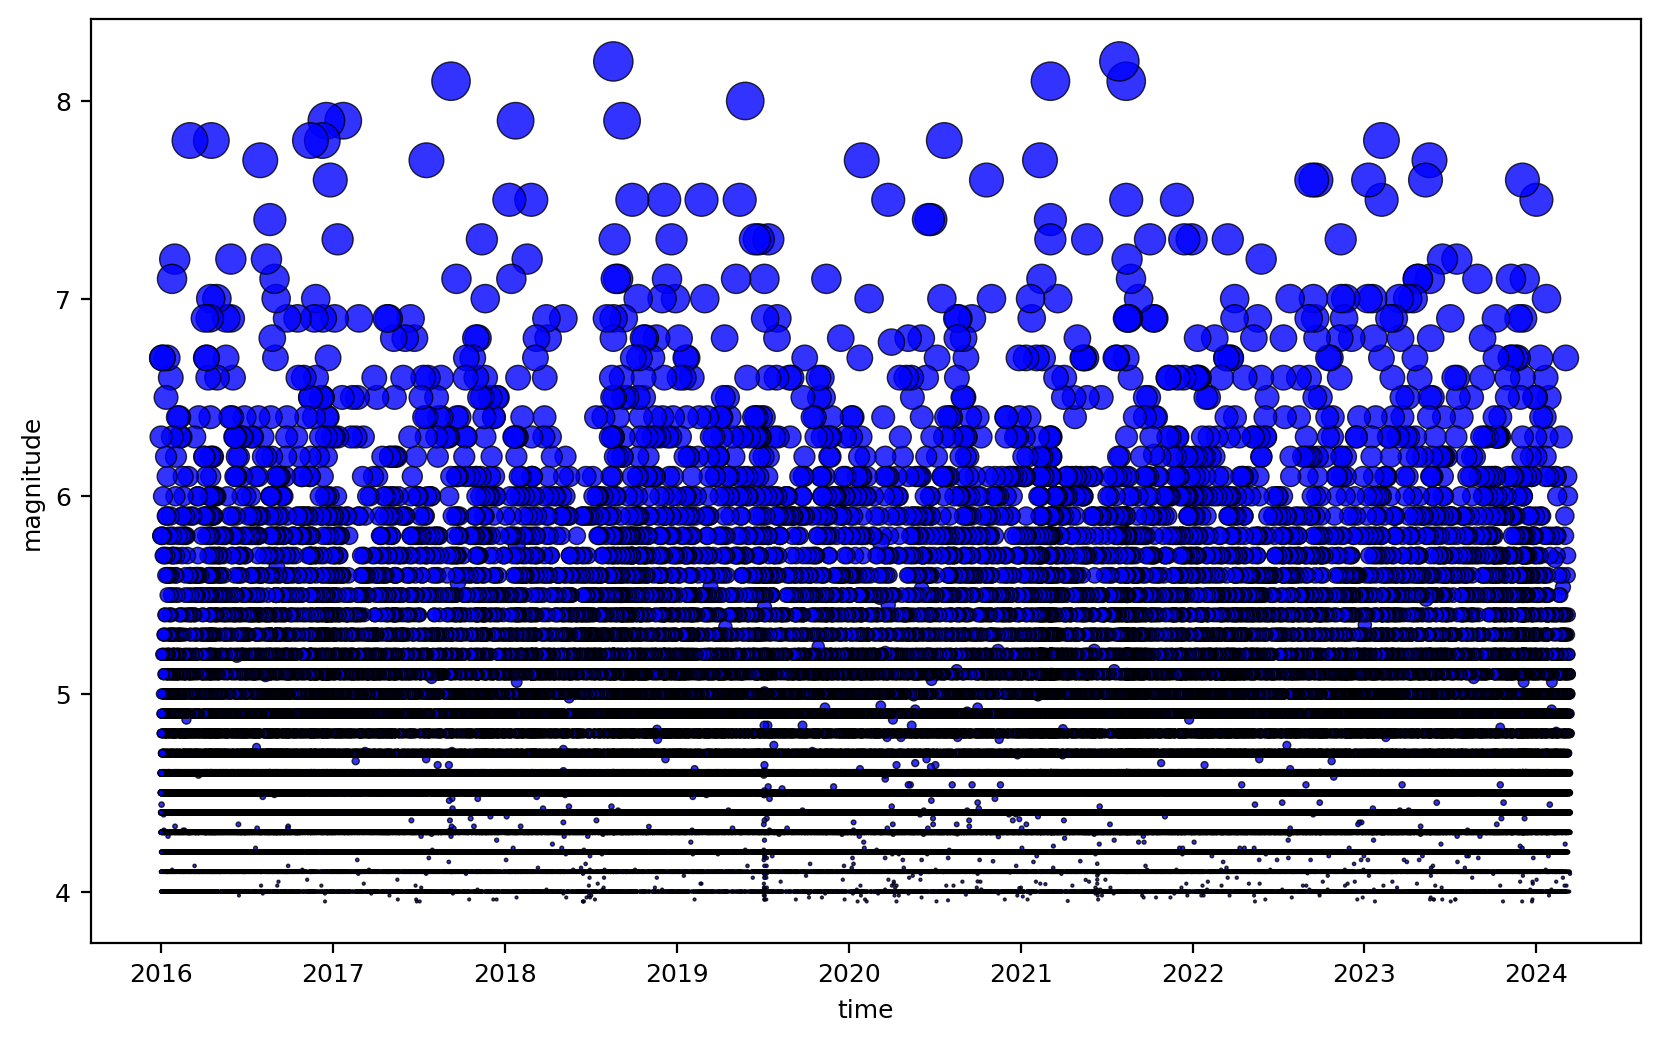

In [50]:
ax = plt.subplots(figsize=(10, 6))[1]
ax = plot_mags_in_time(df, ax=ax, dot_smallest=1)

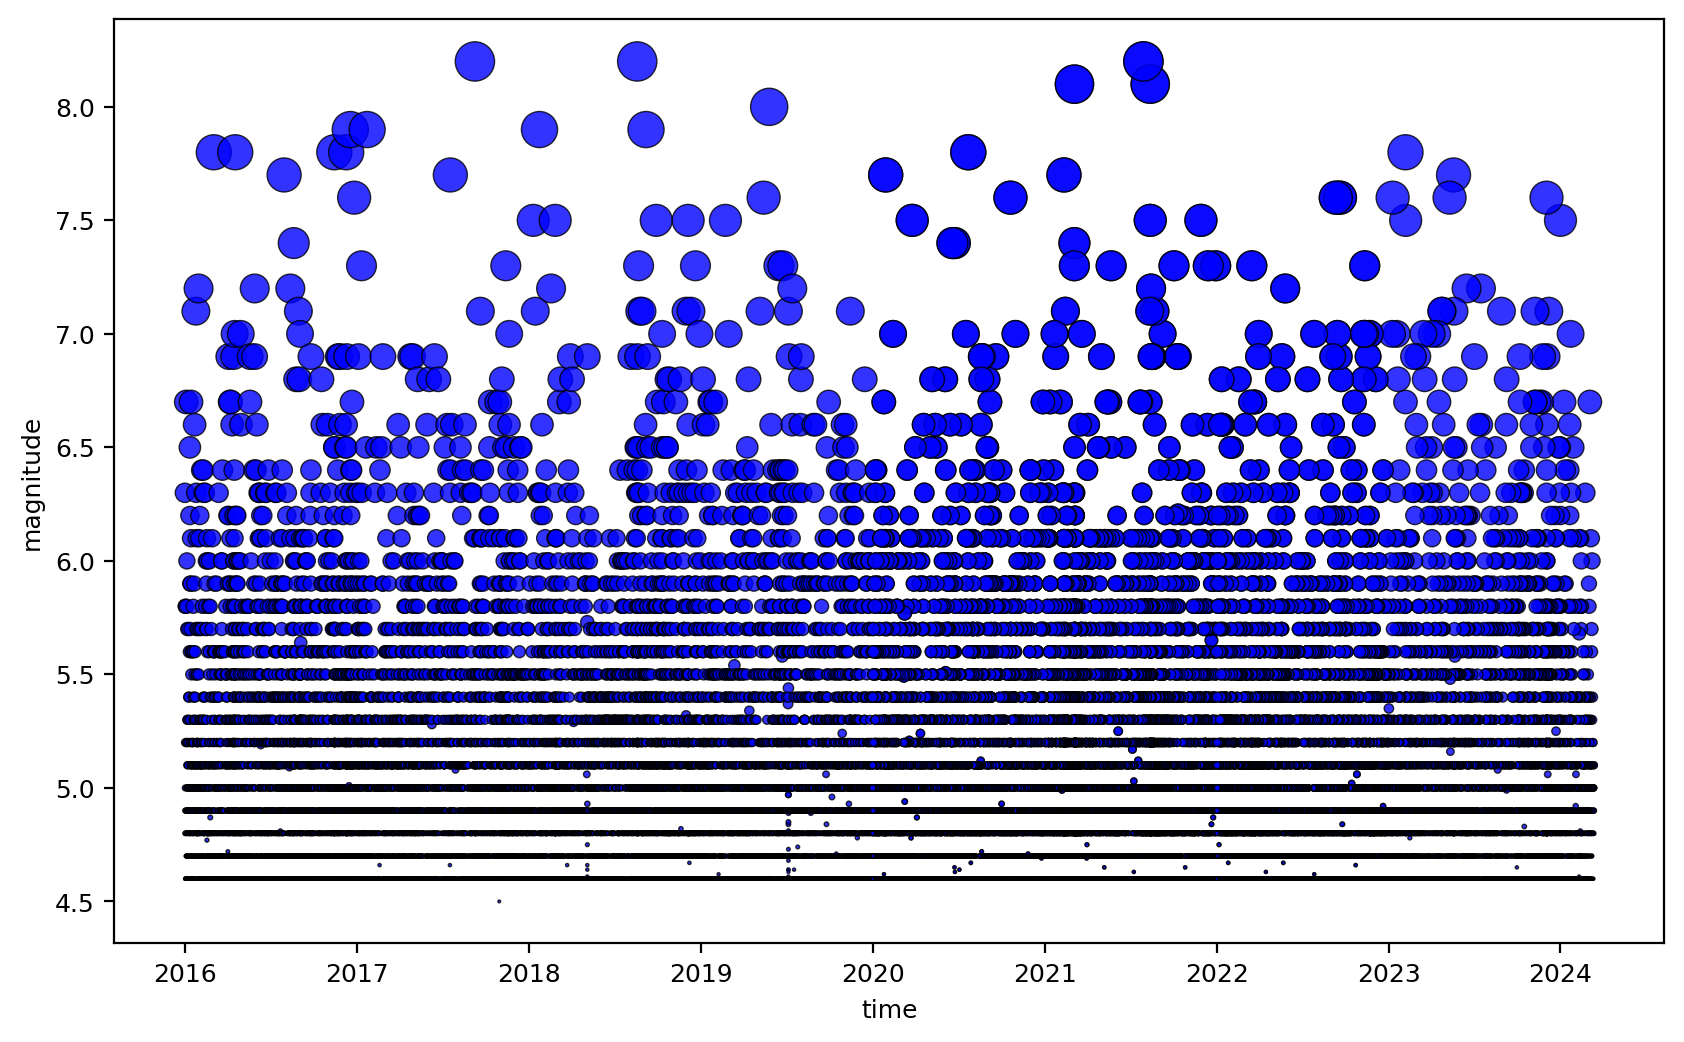

In [27]:
ax = plt.subplots(figsize=(10, 6))[1]
ax = plot_mags_in_time(df, ax=ax, dot_smallest=1)

1.2390463936709972
1.4320286709048828


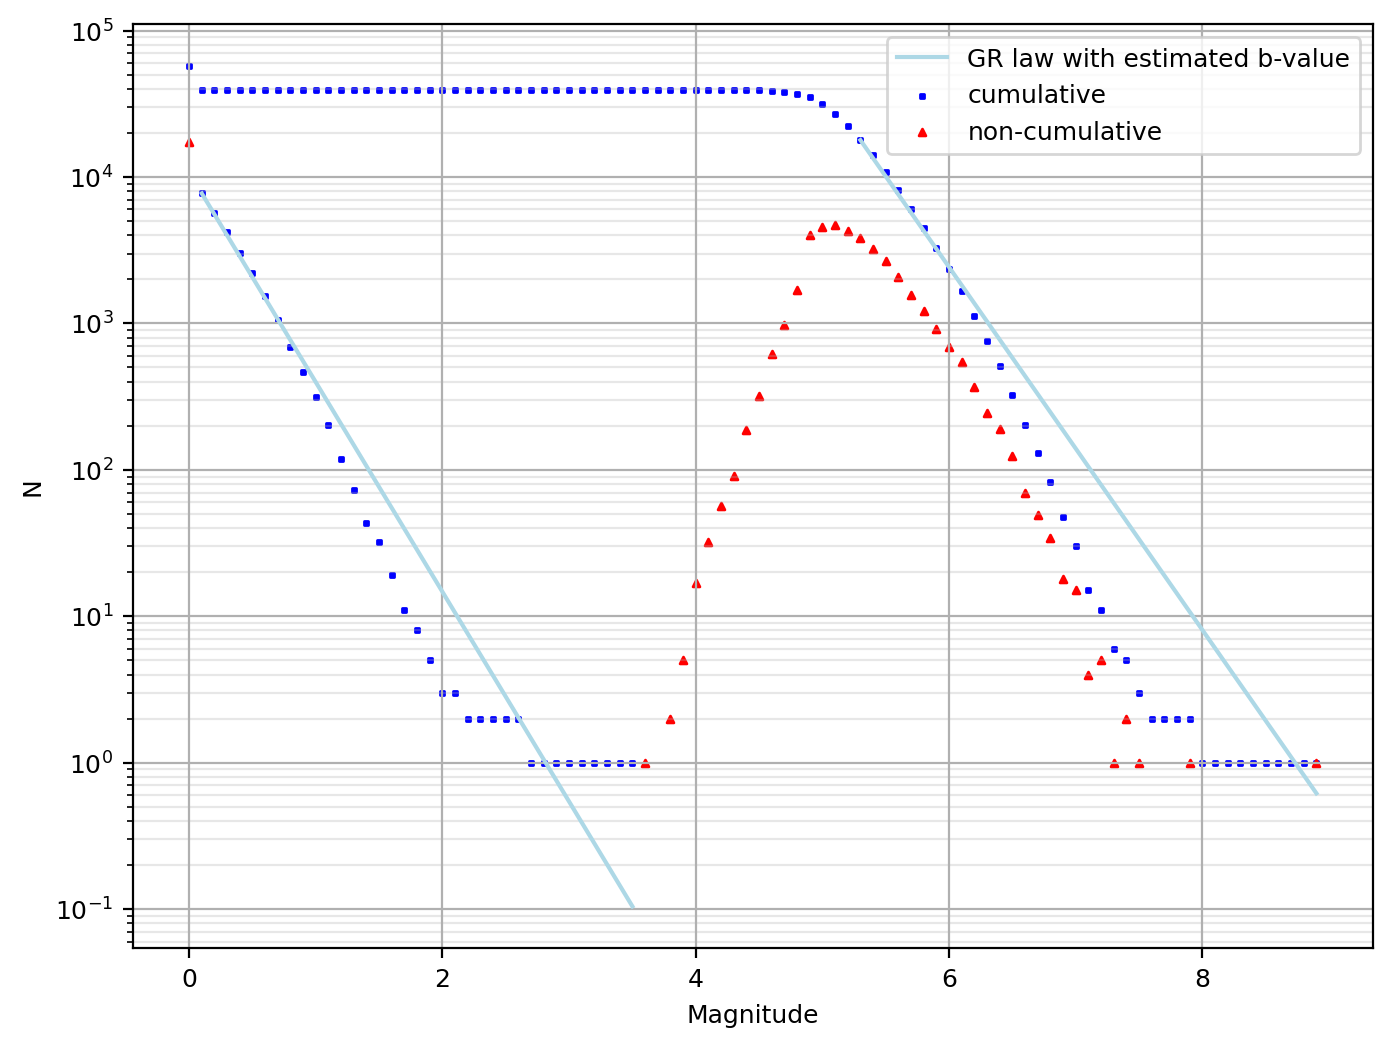

In [96]:
ax = plt.subplots(figsize=(8, 6))[1]

mags = df['magnitude'].values
delta_m = 0.1
mags = bin_to_precision(mags, delta_m)
dates = df['time'].values

mc = 5.3
idx = mags>=mc
mags = mags[idx]
dates = dates[idx]

idx = np.argsort(dates)
mags = mags[idx]
dates = dates[idx]

b_all = estimate_b(mags, mc=mc, delta_m=delta_m, b_parameter='b_value', method='tinti')
print(b_all)
plot_cum_fmd(df['magnitude'], b_value=b_all, mc= mc,delta_m=0.1, ax=ax, color=['blue', 'lightblue'])
plot_fmd(df['magnitude'], ax=ax, color='red', size=6, grid=True)
ax.legend(['GR law with estimated b-value', 'cumulative', 'non-cumulative'])

diffs = np.diff(mags)
diffs = diffs[diffs>0]
b_all = estimate_b(mags, mc=mc, delta_m=delta_m, b_parameter='b_value', method='positive')
plot_cum_fmd(diffs, b_value=b_all, mc=0, delta_m=0.1, color=['blue', 'lightblue'], ax=ax)
print(b_all)

In [119]:
# load dataframe from textfile
df_raw = pd.read_csv('data/world_2016.csv', delimiter=',')
# Data are from USGS

In [120]:
# empty dataframe
df = pd.DataFrame()

# mags
df['magnitude'] = df_raw['mag']

# time
df['time'] = pd.to_datetime(df_raw['time'])

1.2256695084205804
1.1814164475430808


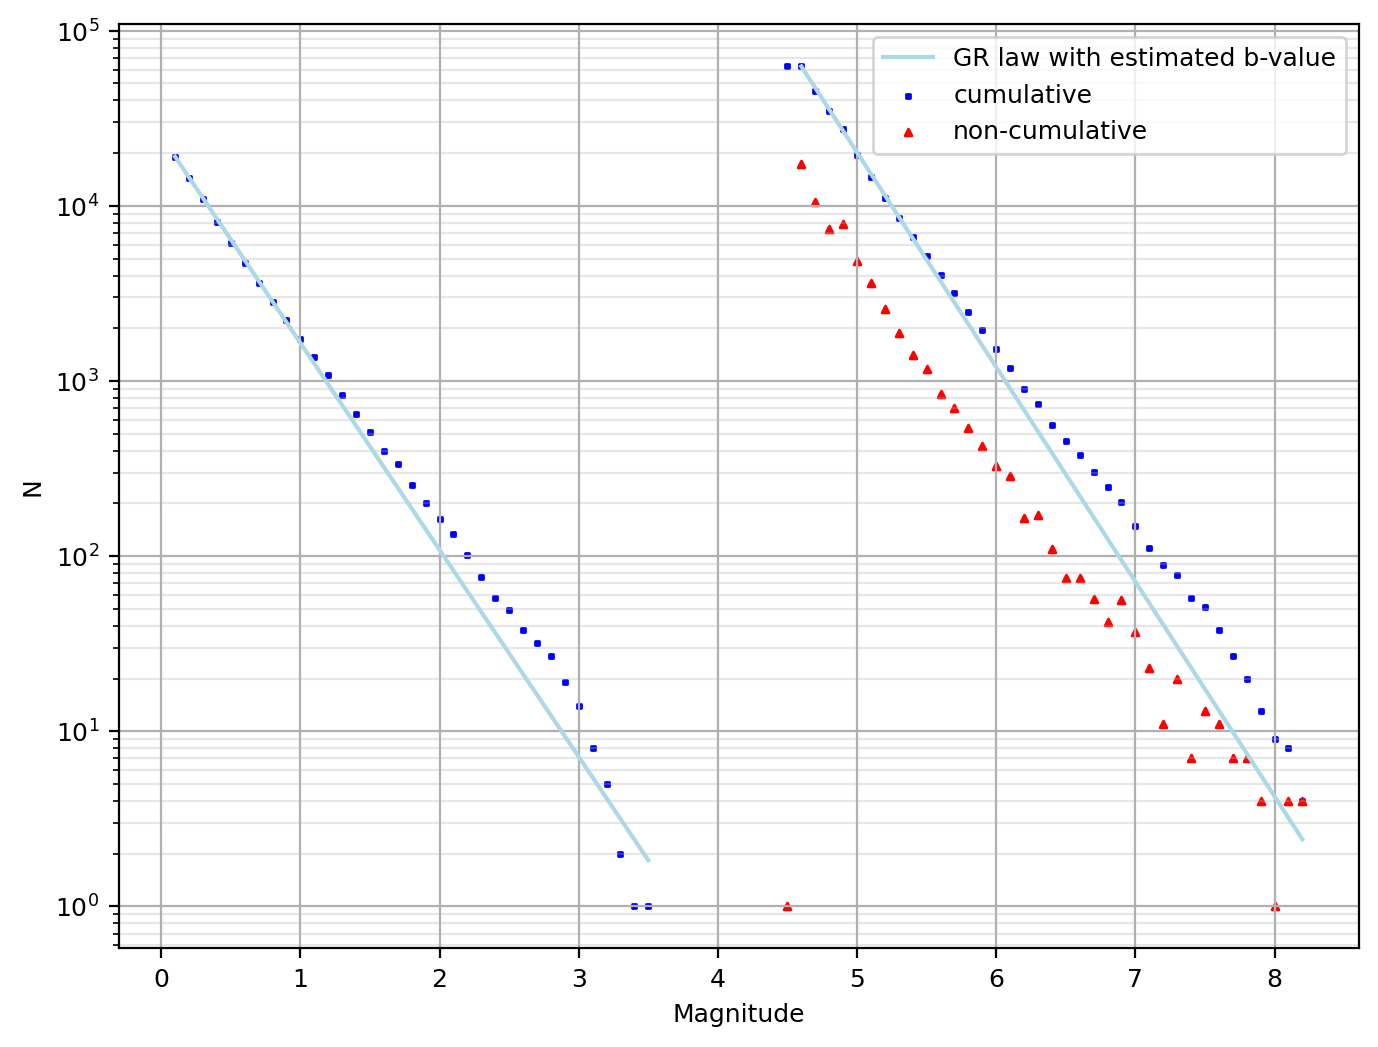

In [122]:
ax = plt.subplots(figsize=(8, 6))[1]

mags = df['magnitude'].values
delta_m = 0.1
mags = bin_to_precision(mags, delta_m)
dates = df['time'].values

mc = 4.6
idx = mags>=mc
mags = mags[idx]
dates = dates[idx]

idx = np.argsort(dates)
mags = mags[idx]
dates = dates[idx]

b_all = estimate_b(mags, mc=mc, delta_m=delta_m, b_parameter='b_value', method='tinti')
print(b_all)
plot_cum_fmd(df['magnitude'], b_value=b_all, mc= mc,delta_m=0.1, ax=ax, color=['blue', 'lightblue'])
plot_fmd(df['magnitude'], ax=ax, color='red', size=6, grid=True)
ax.legend(['GR law with estimated b-value', 'cumulative', 'non-cumulative'])

diffs = np.diff(mags)
diffs = diffs[diffs>0]
b_all = estimate_b(mags, mc=mc, delta_m=delta_m, b_parameter='b_value', method='positive')
plot_cum_fmd(diffs, b_value=b_all, mc=0, delta_m=0.1, color=['blue', 'lightblue'], ax=ax)
print(b_all)

1.1814164475430808


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


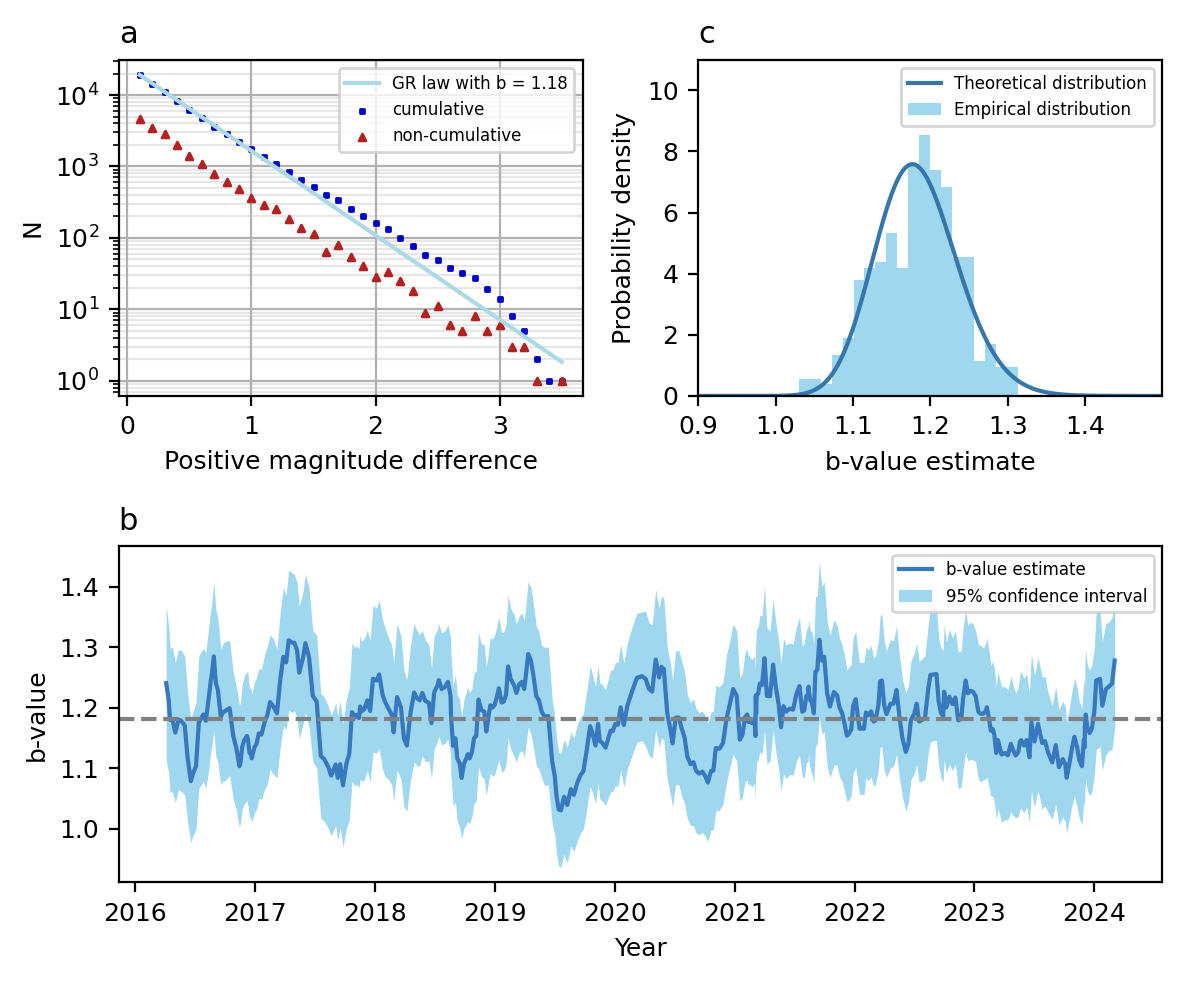

In [135]:
# Create a figure
fig = plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size': 9})
b_est = np.arange(0.9,1.5,0.001)

# Define the subplots
# Top left subplot
ax1 = plt.subplot(2, 2, 1)
mags = df['magnitude'].values
delta_m = 0.1
mags = bin_to_precision(mags, delta_m)
dates = df['time'].values

idx = np.argsort(dates)
mags = mags[idx]
dates = dates[idx]

mc = 4.6
idx = mags>=mc
mags = mags[idx]
dates = dates[idx]
diffs = np.diff(mags)
diffs = diffs[diffs>0]
b_all = estimate_b(mags, mc=0, delta_m=delta_m, b_parameter='b_value', method='positive')
print(b_all)
plot_cum_fmd(diffs, b_value=b_all, mc= 0.0,delta_m=0.1, ax=ax1, color=['mediumblue', 'lightblue'])
plot_fmd(diffs, ax=ax1, color='firebrick', size=6, grid=True)
ax1.set_xlabel('Positive magnitude difference')
ax1.legend(['GR law with b = 1.18', 'cumulative', 'non-cumulative'], fontsize=6)
ax1.set_title('a', fontsize=11, loc='left')
ax1.set_axisbelow(True)

# Top right subplot
ax2 = plt.subplot(2, 2, 2)
b_time, idx_max, b_std = b_any_series(mags, dates, n_b = 500, mc=mc, delta_m=delta_m, return_std=True, overlap=0.9, method='positive')
ax2.plot(b_est, inverse_norm(b_est, b_all, 500), color = '#3776ab', label='Theoretical distribution')
ax2.hist(b_time , color='skyblue', density=True, label='Empirical distribution', bins=20, alpha=0.8)
# limit axis
ax2.set_xlim(min(b_est),max(b_est))
ax2.set_ylim(0,11)
ax2.legend(fontsize=6)


plt.xlabel('b-value estimate')
plt.ylabel('Probability density')

# tight layout
plt.tight_layout()
ax2.set_title('c', fontsize=11, loc='left')

# Bottom subplot spanning two columns
ax3 = plt.subplot(2, 1, 2)
ax3.plot(dates[idx_max], b_time, label='b-value estimate', color='#3778bf')
ax3.fill_between(dates[idx_max], b_time-1.96*b_std, b_time+1.96*b_std, label='95% confidence interval', color='skyblue', alpha=0.8, lw=0)

ax3.axhline(b_all, color='gray', linestyle='--')
ax3.set_xlabel('Year')
ax3.set_ylabel('b-value')
ax3.legend(fontsize=6)
ax3.set_title('b', fontsize=11, loc='left')

plt.tight_layout()
#plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.savefig('../../Article_images/fig1.eps', format='eps')

In [44]:
b_all = estimate_b(mags, mc=0, delta_m=delta_m, b_parameter='b_value', method='positive')
b_time, _, _ = b_any_series(mags, dates, n_b = 200, mc=mc, delta_m=delta_m, return_std=True, overlap=0, method='positive')
ks_dist, p_val_ks, ks_dists = ks_test_b_dist(b_time, mc, delta_m, n_b=200, n=1000, b=b_all)
print(p_val_ks, 'constant')

0.771 constant


p-value for n_b =: 200 [0.66774377]


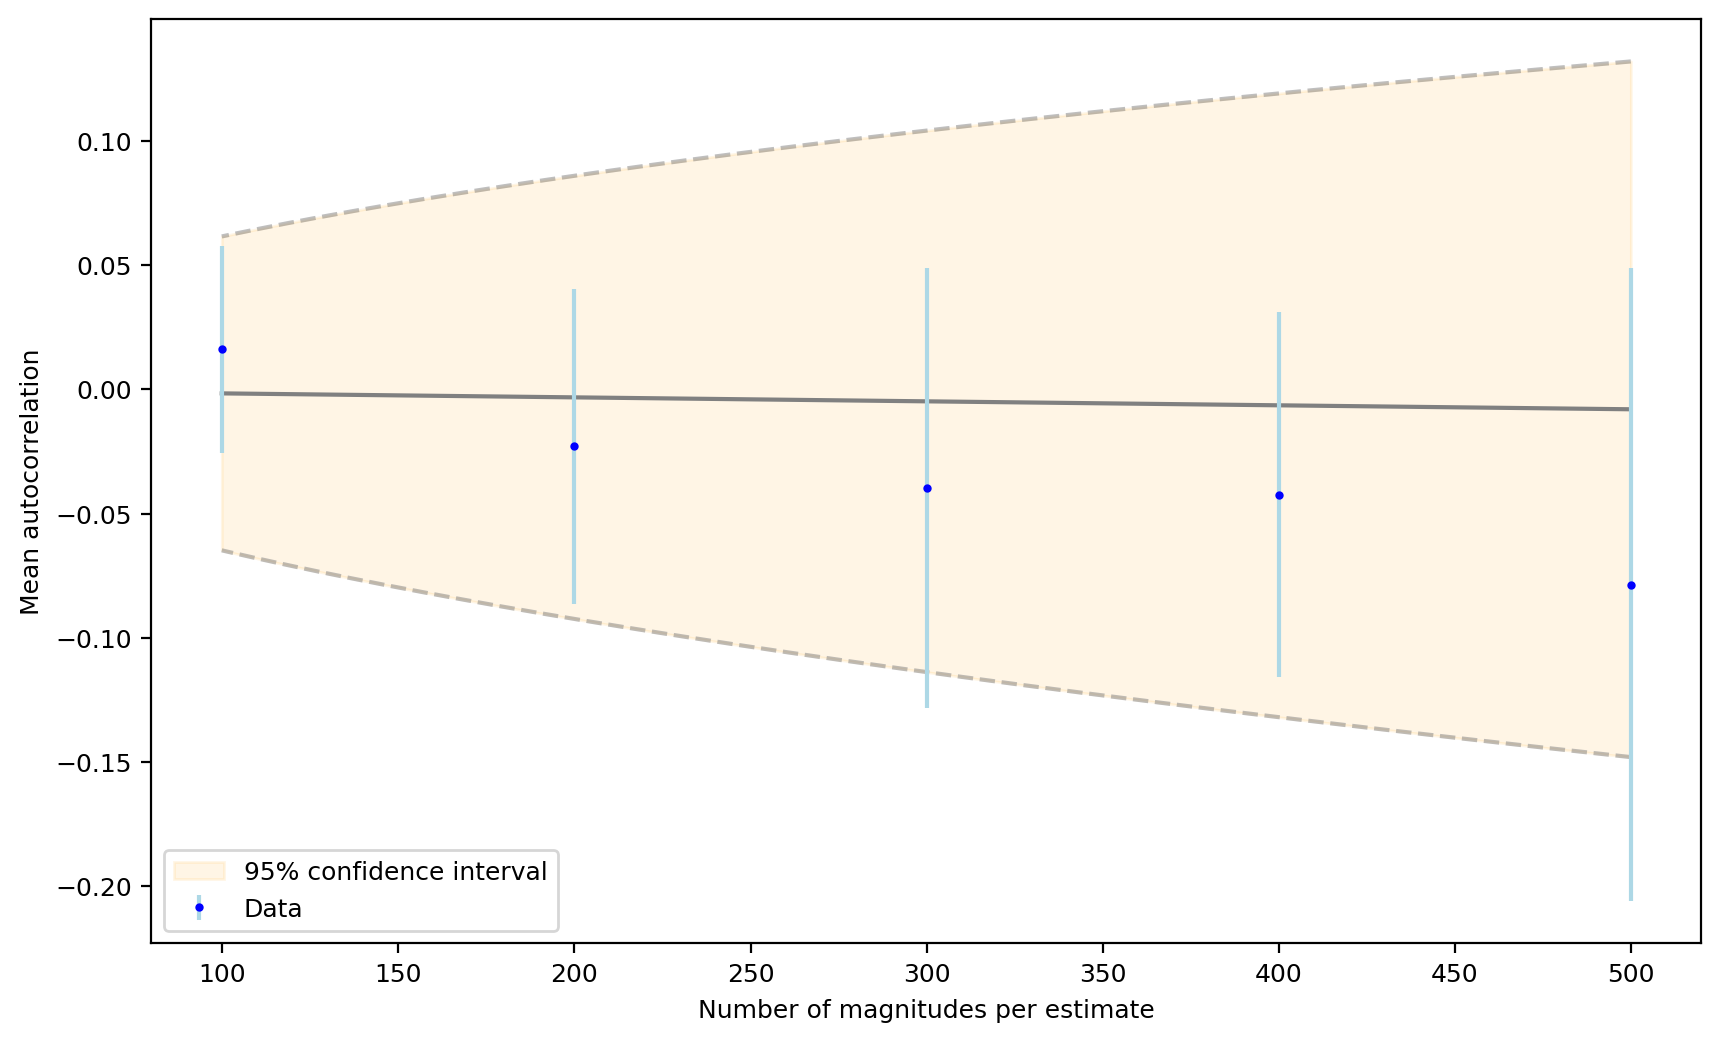

In [45]:
n_bs = np.arange(100, 600, 100)
acfs, acf_std, n_bs, n_series_used = mac_different_n(
    mags,
    dates,
    mc,
    delta_m,
    n_bs=n_bs,
    cutting = 'constant_idx',
    transform = False,
    b_method = "positive",
    plotting=True,
)
print('p-value for n_b =:',200, pval_mac(acfs[n_bs==200], n_series_used[n_bs==200], cutting='constant_idx'))

# Figure 3.b: infogain vs length scale

In [6]:
from functions.eval_functions import mu_sigma_mac, zval_mac
import itertools as it
import pandas as pd

In [5]:
mc = 0
delta_m = 0.1
b = 1
b_parameter = "b_value"
cutting = "constant_idx"
transform = False
n_total = 80000

def lengthscale_deltabs(shape):
    if shape == 'gauss':
        delta_bs = np.arange(0.02, 0.22, 0.02)
        length_scales = np.arange(100, 2000, 150)
    elif shape == 'sinus':
        delta_bs = np.arange(0.02, 0.22, 0.02)
        length_scales = np.arange(200, 4000, 300)
    elif shape == 'rectangle':
        delta_bs = np.arange(0.1, 1.1, 0.1)
        length_scales = np.arange(150, 3000, 150)
    else:
        raise ValueError('shape not recognized')
    all_permutations = [
            i
            for i in it.product(
                delta_bs,
                length_scales,
            )
        ]
    all_permutations = np.array(all_permutations)
    # parameter vectors to run through with cl_idx
    cl_delta_bs = all_permutations[:, 0]
    cl_length_scales = all_permutations[:, 1].astype(int)
    return length_scales, delta_bs, cl_length_scales, cl_delta_bs,

def get_string_data(cl_idx, shape):
    if shape == 'gauss':
        save_str = (
                "results/length_scale/constant_idx/"
                "df_"+ shape + str(cl_idx) + ".csv"
            )
    elif shape == 'sinus':
        save_str = (
                "results/length_scale/constant_idx/"
                "df_" + shape + str(cl_idx) + ".csv"
            )
    elif shape == 'rectangle':
        save_str = (
                "results/length_scale/constant_idx/"
                "df_" + shape + str(cl_idx) + ".csv"
            )
    else:
        raise ValueError('shape not recognized')
    return save_str

def get_df(shape):
    df = pd.DataFrame()
    _, _, cl_length_scales, cl_delta_bs, = lengthscale_deltabs(shape)

    for cl_idx in range(len(cl_delta_bs)):
        save_str = get_string_data(cl_idx, shape)
        df_loop = pd.read_csv('../'+save_str, sep=',')
        df_loop['delta b'] = cl_delta_bs[cl_idx]
        df_loop['length scale'] = cl_length_scales[cl_idx]
        # add to df
        df = pd.concat([df, df_loop], ignore_index=True)
    return df

def get_eval_df(shape):
    df = get_df(shape)
    length_scales, delta_bs, _, _ = lengthscale_deltabs(shape)

    max_ig_here = []
    max_ig_next = []
    max_ig_next1 = []
    n_max_ig_here = []
    n_max_ig_next = []
    n_max_ig_next1 = []
    n_max_acf = []
    max_acf = []
    n_max_zval = []
    max_zval = []
    delta_b_all = []
    length_scale_all = []
    sim_number_all = []
    inv_ig_here = []
    inv_ig_next = []
    inv_ig_next1 = []
    
    for delta_b in delta_bs:
        for length_scale in length_scales:
            for sim_num in np.arange(10):
                df_loop = df[(df['delta b'] == delta_b) & (df['length scale'] == length_scale) & (df['sim_number'] == sim_num)]
                ig_here = df_loop['ig_here'].values
                ig_next = df_loop['ig_next'].values
                ig_next1 = df_loop['ig_next1'].values
                n_b = df_loop['n_b'].values
                acf = df_loop['acf'].values
                z_val = zval_mac(acf,n_total/n_b,cutting=cutting)
                n_max_ig_here.append(n_b[np.argmax(ig_here)])
                max_ig_here.append(np.max(ig_here))
                n_max_ig_next.append(n_b[np.argmax(ig_next)])
                max_ig_next.append(max(ig_next))
                n_max_ig_next1.append(n_b[np.argmax(ig_next1)])
                max_ig_next1.append(max(ig_next1))
                n_max_acf.append(n_b[np.argmax(acf)])
                inv_ig_here.append(ig_here[np.argmax(acf)])
                inv_ig_next.append(ig_next[np.argmax(acf)])
                inv_ig_next1.append(ig_next1[np.argmax(acf)])
                max_acf.append(np.max(acf))
                n_max_zval.append(n_b[np.argmax(z_val)])
                max_zval.append(np.max(z_val))
                delta_b_all.append(delta_b)
                length_scale_all.append(length_scale)
                sim_number_all.append(sim_num)
    
    # estimate the z-score
    n_max_acf=np.array(n_max_acf)
    z_val = zval_mac(max_acf,n_total/n_max_acf,cutting=cutting) 

    # make dataframe of the results
    df_eval = pd.DataFrame({'n_max_ig_here': n_max_ig_here,
                        'max_ig_here': max_ig_here,
                        'n_max_ig_next': n_max_ig_next,
                        'max_ig_next': max_ig_next,
                        'n_max_ig_next1': n_max_ig_next1,
                        'max_ig_next1': max_ig_next1,
                        'n_max_acf': n_max_acf,
                        'inv_ig_here': inv_ig_here,
                        'inv_ig_next': inv_ig_next,
                        'inv_ig_next1': inv_ig_next1,
                        'max_acf': max_acf,
                        'n_max_zval': n_max_zval,
                        'max_zval': max_zval,
                        'delta b': delta_b_all,
                        'length scale': length_scale_all,
                        'sim number': sim_number_all,
                        'z_val': z_val})
    return df_eval

In [6]:
df_eval_gauss = get_eval_df('gauss')
df_eval_sinus = get_eval_df('sinus')
df_eval_rectangle = get_eval_df('rectangle')

share of selected models 0.48538461538461536
positive share thereof 0.34310618066561016
resulting in 0.16653846153846155
versus actually 0.4938461538461538


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_20611/2825249538.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


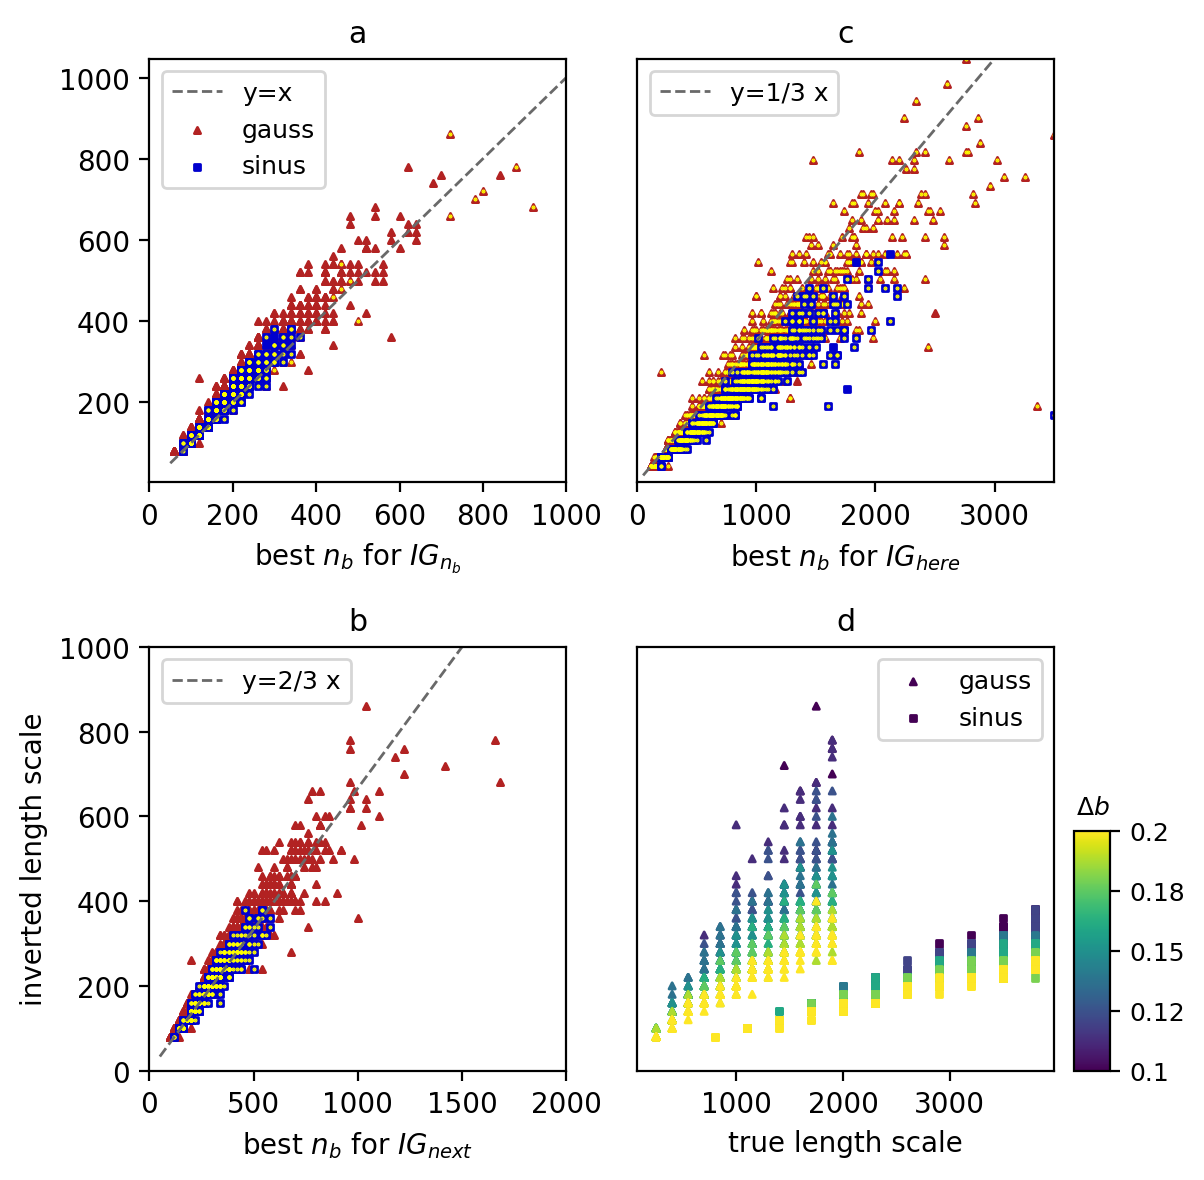

In [7]:
# Create a figure
fig, axs = plt.subplots(2, 3, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 0.1]})


plt.rcParams.update({'font.size': 9})

ig_str = 'ig_next'
max_str = 'acf'
threshold = 0.5

x1 = np.arange(50,1000)
axs[0,0].plot(x1,x1, label='y=x', color='dimgrey', linestyle='--', linewidth=1)

#df_filter = df_eval_rectangle[(df_eval_rectangle['max_'+max_str] > threshold)]
#total = len(df_filter)
#axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='*', s=6 ,label= 'rectangle', color='forestgreen')
#df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
#pos = len(df_filter)
#axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=0.2 , color='yellow')

df_filter = df_eval_gauss[(df_eval_gauss['max_'+max_str] > threshold)]
total = len(df_filter)
#total += len(df_filter)
axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', label= 'gauss', s=5, color='firebrick')
df_filter = df_filter[(df_filter['max_'+ig_str] < 0)]
pos = len(df_filter)
#pos += len(df_filter)
axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', color='yellow', s=0.2)
axs[0, 0].yaxis. tick_right() 


#df_filter = df_eval_sinus[(df_eval_sinus['max_'+max_str] > threshold)]
#total += len(df_filter)
#ax.scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str],  marker='*', label= 'sinus')
#df_filter = df_filter[(df_filter['inv_'+ig_str] > 0)]
#pos += len(df_filter)
#ax.scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=1, color='yellow')

df_filter = df_eval_sinus[(df_eval_sinus['max_'+max_str] > threshold)]
total += len(df_filter)
axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str],  marker='s', label= 'sinus', s=5, color='mediumblue')
df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
pos += len(df_filter)
axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=0.2, color='yellow')

axs[0,0].set_xlabel('best $n_b$ for $IG_{n_b}$')
axs[0,0].legend()

# set the title
axs[0,0].set_title('a')

# share of all positive IG vs negative
share_pos = pos/total
share_sel = total/(len(df_eval_gauss)+len(df_eval_sinus))#+len(df_eval_rectangle))
pos_actual = (
    len(df_eval_sinus[(df_eval_sinus['max_'+ig_str] > 0)])+
    len(df_eval_gauss[(df_eval_gauss['max_'+ig_str] > 0)])#+
    #len(df_eval_rectangle[(df_eval_rectangle['max_'+ig_str] > 0)])
        )
share_pos_act = pos_actual/(len(df_eval_gauss)+len(df_eval_sinus))#+len(df_eval_rectangle))
print('share of selected models', share_sel)
print('positive share thereof', share_pos)
print('resulting in', share_sel*share_pos)
print('versus actually', share_pos_act)

# limits
axs[0,0].set_xlim(0,1000)
axs[0,0].yaxis.tick_left() 

# =============================================================================
# =============================================================================
ig_str = 'ig_next1'
max_str = 'acf'
threshold = 0.5

x1 = np.arange(50,2000)
axs[1,0].plot(x1,2/3*x1, label='y=2/3 x', color='dimgrey', linestyle='--', linewidth=1)

#df_filter = df_eval_rectangle[(df_eval_rectangle['max_'+max_str] > threshold)]
#total = len(df_filter)
#axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='*', s=6 ,label= 'rectangle', color='forestgreen')
#df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
#pos = len(df_filter)
#axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=0.2 , color='yellow')

df_filter = df_eval_gauss[(df_eval_gauss['max_'+max_str] > threshold)]
total = len(df_filter)
#total += len(df_filter)
axs[1,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, color='firebrick')
df_filter = df_filter[(df_filter['max_'+ig_str] < 0)]
pos = len(df_filter)
#pos += len(df_filter)
axs[1,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', color='yellow', s=0.2)
axs[1, 0].yaxis. tick_right() 


#df_filter = df_eval_sinus[(df_eval_sinus['max_'+max_str] > threshold)]
#total += len(df_filter)
#ax.scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str],  marker='*', label= 'sinus')
#df_filter = df_filter[(df_filter['inv_'+ig_str] > 0)]
#pos += len(df_filter)
#ax.scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=1, color='yellow')

df_filter = df_eval_sinus[(df_eval_sinus['max_'+max_str] > threshold)]
total += len(df_filter)
axs[1,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str],  marker='s', s=5, color='mediumblue')
df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
pos += len(df_filter)
axs[1,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=0.2, color='yellow')

axs[1,0].set_xlabel('best $n_b$ for $IG_{next}$')
axs[1,0].set_ylabel('inverted length scale')
axs[1,0].legend()


# set the title
axs[1,0].set_title('b')

# limits
axs[1,0].set_xlim(0,2000)
axs[1,0].set_ylim(0,1000)
axs[1,0].yaxis.tick_left() 
# =============================================================================
# =============================================================================

ig_str = 'ig_here'
max_str = 'acf'
threshold = 0.2

x1 = np.arange(50,3400)
axs[0,1].plot(x1,x1/3, label='y=1/3 x', color='dimgrey', linestyle='--', linewidth=1)

#df_filter = df_eval_rectangle[(df_eval_rectangle['max_'+max_str] > threshold)]
#total = len(df_filter)
#axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='*', s=6 ,label= 'rectangle', color='forestgreen')
#df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
#pos = len(df_filter)
#axs[0,0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=0.2 , color='yellow')

df_filter = df_eval_gauss[(df_eval_gauss['max_'+max_str] > threshold)]
total = len(df_filter)
#total += len(df_filter)
axs[0,1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, color='firebrick')
df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
pos = len(df_filter)
#pos += len(df_filter)
axs[0,1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', color='yellow', s=0.2)
axs[0, 1].yaxis. tick_right() 


#df_filter = df_eval_sinus[(df_eval_sinus['max_'+max_str] > threshold)]
#total += len(df_filter)
#ax.scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str],  marker='*', label= 'sinus')
#df_filter = df_filter[(df_filter['inv_'+ig_str] > 0)]
#pos += len(df_filter)
#ax.scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=1, color='yellow')

df_filter = df_eval_sinus[(df_eval_sinus['max_'+max_str] > threshold)]
total += len(df_filter)
axs[0,1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str],  marker='s', s=5, color='mediumblue')
df_filter = df_filter[(df_filter['max_'+ig_str] > 0)]
pos += len(df_filter)
axs[0,1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=0.2, color='yellow')

axs[0,1].set_xlabel('best $n_b$ for $IG_{here}$')
axs[0,1].legend()

# set the title
axs[0,1].set_title('c')

# limits
axs[0,1].set_xlim(0,3500)
axs[0,1].set_ylim(0,1000)
axs[0, 1].axes.get_yaxis().set_visible(False)

# =============================================================================
# =============================================================================

threshold = 0.5

df_filter = df_eval_gauss[(df_eval_gauss['max_acf'] > threshold)]
cs = axs[1,1].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='^', label= 'gauss', c=df_filter['delta b'], s=5)

df_filter = df_eval_sinus[(df_eval_sinus['max_acf'] > threshold)]
axp = axs[1,1].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='s', label= 'sinus', c=df_filter['delta b'], s=5)

axs[1,1].set_xlabel('true length scale')
axs[1,1].legend()

# set the title
axs[1,1].set_title('True vs. inverted length scale')

# colorbar 
#adding colorbar and its position
import matplotlib.ticker as tkr
cbaxes = fig.add_axes([0.9, 0.1, 0.03, 0.2])  
cb = plt.colorbar(axp, cax = cbaxes, format=tkr.FormatStrFormatter('%.2g'))
cb.set_label('$\Delta b$', labelpad=-33, y=1.15, rotation=0)
axs[1,1].set_ylim(0,1000)
axs[1, 1].axes.get_yaxis().set_visible(False)
axs[1,1].set_title('d')

axs[1,2].set_axis_off()
axs[0,2].set_axis_off()


import matplotlib.pyplot as pyplt
pyplt.rcParams["figure.figsize"] = (18, 10)
# tight
plt.tight_layout()

plt.savefig('../../Article_images/fig3b.eps', format='eps')

In [8]:
df_eval_gauss

n_max_ig_here  max_ig_here  n_max_ig_next  max_ig_next  n_max_ig_next1  \
0              3899    -0.000071           3979    -0.000115            3960   
1              3780    -0.000056           3979    -0.000095            3979   
2              3979    -0.000073           3979    -0.000106            3878   
3              3979    -0.000124           3979    -0.000128            3820   
4              3840    -0.000087           3960    -0.000120            3799   
...             ...          ...            ...          ...             ...   
1295           1340     0.020702            240     0.018034             400   
1296           1300     0.010069            280     0.007472             420   
1297           1080     0.011679            260     0.009134             440   
1298           1160     0.023909            240     0.021132             360   
1299           1200     0.014861            240     0.012286             400   

      max_ig_next1  n_max_acf  inv_ig_here  inv_ig_next  inv_ig_next1  \
0        -0.000112       1240    -0.000303    -0.000371     -0.000371   
1        -0.000078       3920    -0.000079    -0.000097     -0.000089   
2        -0.000089        340    -0.001376    -0.001471     -0.001431   
3        -0.000136       1500    -0.000306    -0.000369     -0.000347   
4        -0.000112        700    -0.000622    -0.000723     -0.000634   
...            ...        ...          ...          ...           ...   
1295      0.019244        320     0.019538     0.017801      0.019168   
1296      0.008643        360     0.009106     0.007244      0.008587   
1297      0.010352        320     0.010668     0.008987      0.010227   
1298      0.022448        300     0.022847     0.020884      0.022387   
1299      0.013557        260     0.013541     0.012267      0.013270   

       max_acf  n_max_zval   max_zval  delta b  length scale  sim number  \
0     0.064149         760   0.834276     0.02           100           0   
1     0.191464        3920   1.451975     0.02           100           1   
2     0.045250         320   0.952727     0.02           100           2   
3     0.121869          20   2.621010     0.02           100           3   
4     0.038852          20   0.956938     0.02           100           4   
...        ...         ...        ...      ...           ...         ...   
1295  0.882860          40  31.726624     0.20          1900           5   
1296  0.811829          60  24.655779     0.20          1900           6   
1297  0.811257          60  26.082364     0.20          1900           7   
1298  0.873855          40  29.776244     0.20          1900           8   
1299  0.838655          40  28.277828     0.20          1900           9   

          z_val  
0      0.809883  
1      1.451975  
2      0.944743  
3      1.306641  
4      0.637528  
...         ...  
1295  17.440798  
1296  15.147098  
1297  16.032669  
1298  17.818061  
1299  18.347215  

[1300 rows x 17 columns]

IG next:  0.65
lost positive:  0
IG mid:  0.9355769230769231
true length:  0.9620192307692308


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_20611/3616169923.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


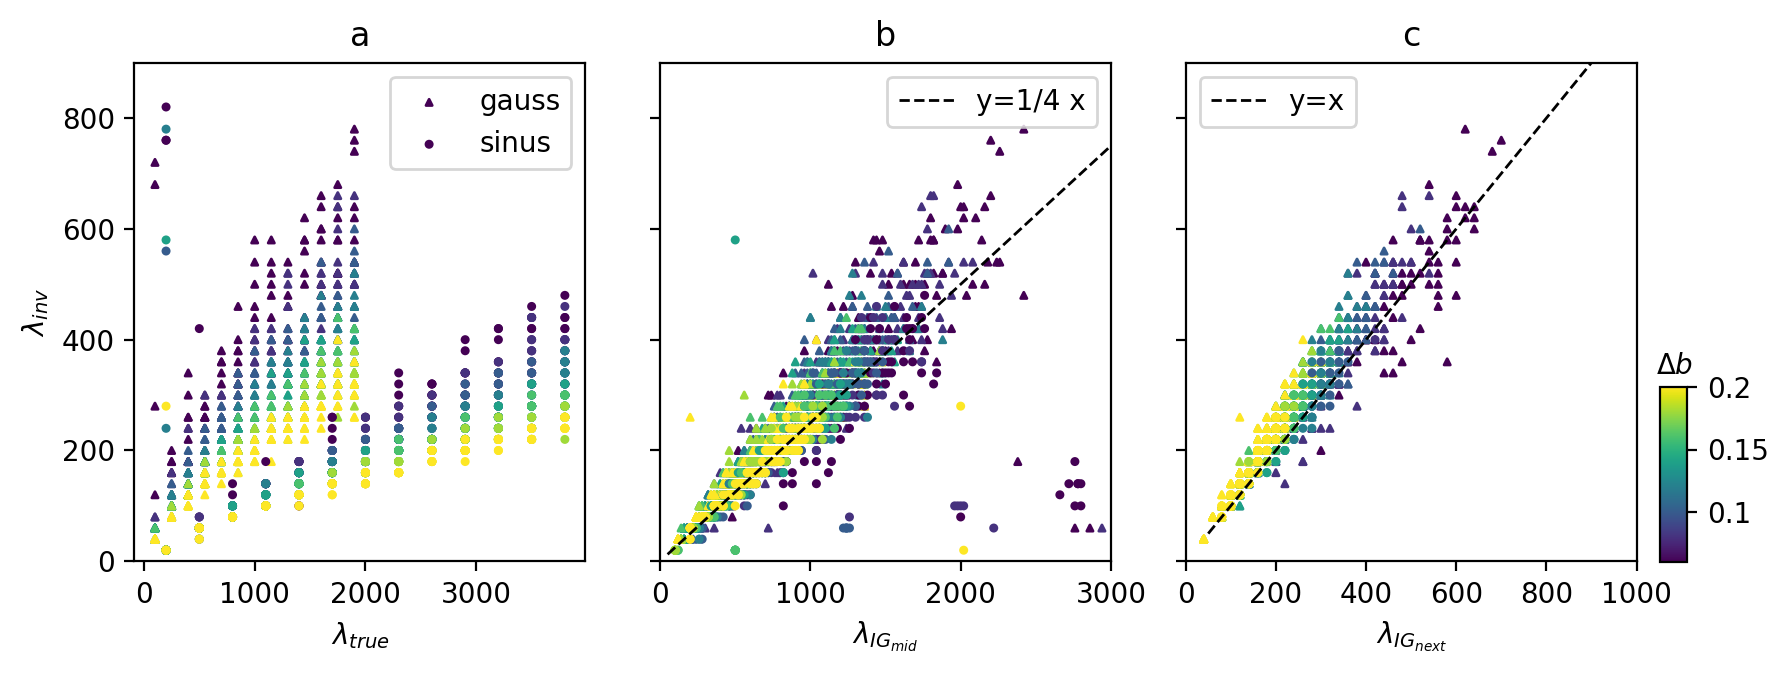

In [11]:
thresh_str = 'delta b'  #--> for filtering
thresh = 0.05

# Create a figure
fig, axs = plt.subplots(1, 4, figsize=(9, 3.5), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})


plt.rcParams.update({'font.size': 10})

ig_str = 'ig_next'
max_str = 'acf'

x1 = np.arange(50,1000)
axs[2].plot(x1,x1, label='y=x', color='k', linestyle='--', linewidth=1)


df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos =  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])
axs[2].yaxis. tick_right() 
axs[2].set_yticklabels([])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
#n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
#axs[0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', label= 'rect', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[2].set_xlabel('$\lambda_{IG_{next}}$')
axs[2].legend()

# set the title
axs[2].set_title('c')

# limits
axs[2].set_xlim(0,1000)
axs[2].set_ylim(0,900)
axs[2].yaxis.tick_left() 
# y label
axs[0].set_ylabel('$\lambda_{inv}$')

# share of models not displayed
print('IG next: ', n_showed/n_total)
# share of lost positive models:
print('lost positive: ', n_notshowedpos)
# =============================================================================
# =============================================================================

ig_str = 'ig_here'
max_str = 'acf'

x1 = np.arange(50,4000)
axs[1].plot(x1,x1/4, label='y=1/4 x', color='k', linestyle='--', linewidth=1)

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<3000) & (df_filter['n_max_'+max_str]<900))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<2000))
#axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<3000) & (df_filter['n_max_'+max_str]<900))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[1].set_xlabel('$\lambda_{IG_{mid}}$')
axs[1].legend()

# set the title
axs[1].set_title('b')

# limits
axs[1].set_xlim(0,3000)
axs[1].set_ylim(0,900)
axs[1].set_yticklabels([])

# share of models not displayed
print('IG mid: ', n_showed/n_total)
# =============================================================================
# =============================================================================

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum(df_filter['n_max_'+max_str]<900)
cs = axs[0].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='^', label= 'gauss', c=df_filter['delta b'], s=5)

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum(df_filter['n_max_'+max_str]<2000)
#axp = axs[2].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum(df_filter['n_max_'+max_str]<900)
axp = axs[0].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

axs[0].set_xlabel('$\lambda_{true}$')
#axs[2].legend()

# colorbar 
#adding colorbar and its position
import matplotlib.ticker as tkr
cbaxes = fig.add_axes([0.93, 0.18, 0.015, 0.25])  
cb = plt.colorbar(axp, cax = cbaxes, format=tkr.FormatStrFormatter('%.2g'))
cb.set_label('$\Delta b$', labelpad=-34, y=1.2, rotation=0)
axs[0].set_ylim(0,900)
axs[0].set_title('a')
axs[0].legend()

axs[3].set_axis_off()


# share of models not displayed
print('true length: ', n_showed/n_total)

import matplotlib.pyplot as pyplt
pyplt.rcParams["figure.figsize"] = (18, 10)
# tight
plt.tight_layout()



IG next:  0.65
lost positive:  0
IG mid:  0.9432692307692307
true length:  1.0


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_20611/2286150624.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


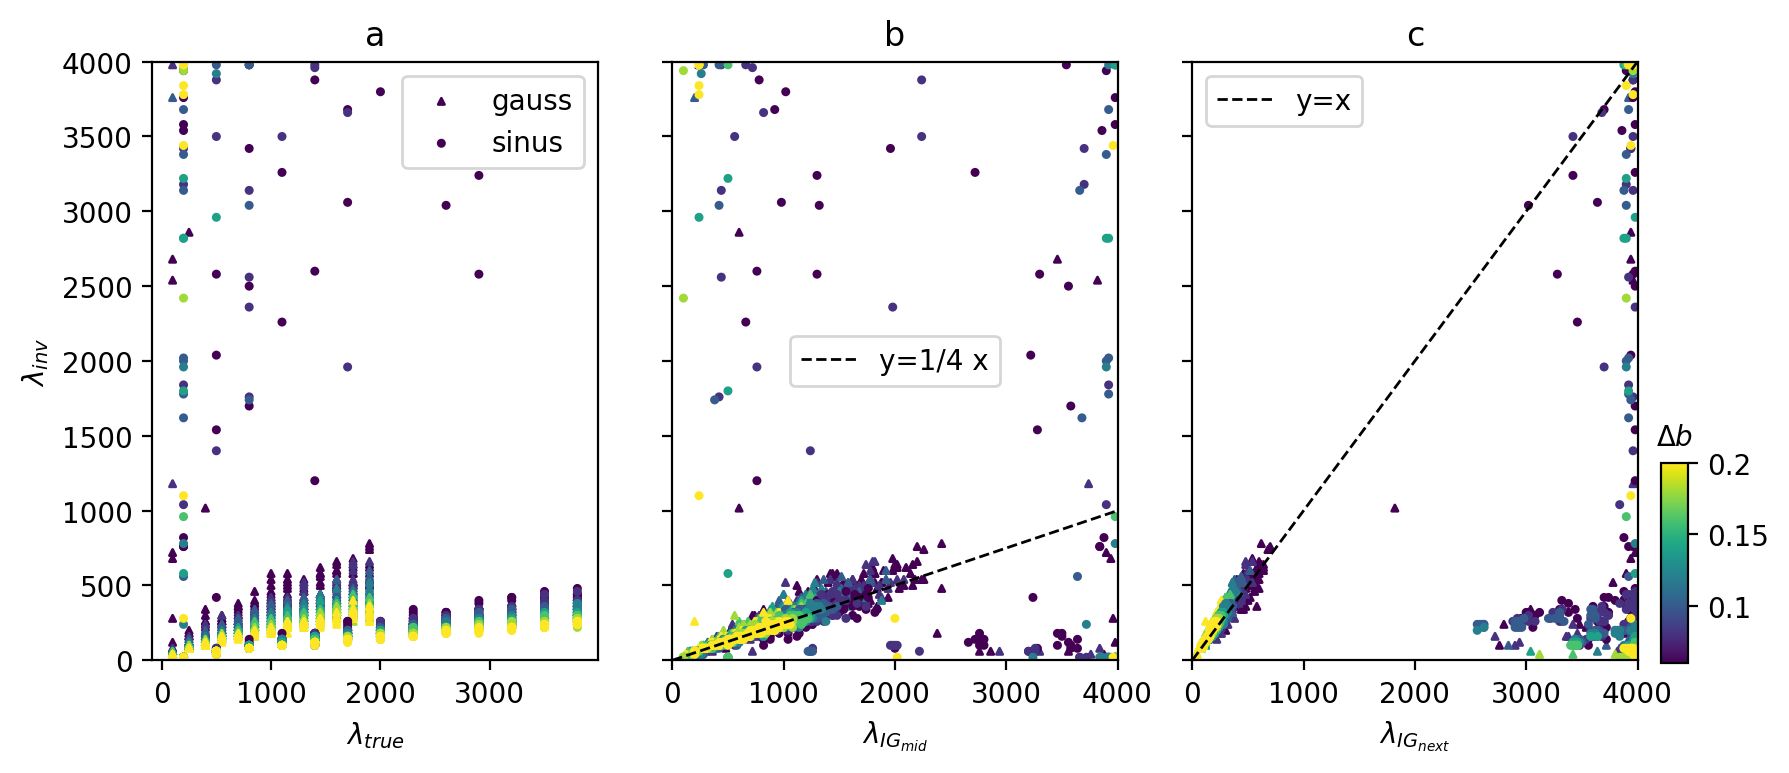

In [12]:
thresh_str = 'delta b'  #--> for filtering
thresh = 0.05

# Create a figure
fig, axs = plt.subplots(1, 4, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})


plt.rcParams.update({'font.size': 10})

ig_str = 'ig_next'
max_str = 'acf'

x1 = np.arange(0,4000)
axs[2].plot(x1,x1, label='y=x', color='k', linestyle='--', linewidth=1)


df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos =  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])
axs[2].yaxis. tick_right() 
axs[2].set_yticklabels([])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
#n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
#axs[0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', label= 'rect', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[2].set_xlabel('$\lambda_{IG_{next}}$')
axs[2].legend()

# set the title
axs[2].set_title('c')

# limits
axs[2].set_xlim(0,4000)
axs[2].set_ylim(0,4000)
axs[2].yaxis.tick_left() 
# y label
axs[0].set_ylabel('$\lambda_{inv}$')

# share of models not displayed
print('IG next: ', n_showed/n_total)
# share of lost positive models:
print('lost positive: ', n_notshowedpos)
# =============================================================================
# =============================================================================

ig_str = 'ig_here'
max_str = 'acf'

x1 = np.arange(0,4000)
axs[1].plot(x1,x1/4, label='y=1/4 x', color='k', linestyle='--', linewidth=1)

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<4000))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<2000))
#axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<3000) & (df_filter['n_max_'+max_str]<900))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[1].set_xlabel('$\lambda_{IG_{mid}}$')
axs[1].legend()

# set the title
axs[1].set_title('b')

# limits
axs[1].set_xlim(0,4000)
axs[1].set_ylim(0,4000)
axs[1].set_yticklabels([])

# share of models not displayed
print('IG mid: ', n_showed/n_total)
# =============================================================================
# =============================================================================

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum(df_filter['n_max_'+max_str]<4000)
cs = axs[0].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='^', label= 'gauss', c=df_filter['delta b'], s=5)

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum(df_filter['n_max_'+max_str]<2000)
#axp = axs[2].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum(df_filter['n_max_'+max_str]<4000)
axp = axs[0].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

axs[0].set_xlabel('$\lambda_{true}$')
#axs[2].legend()

# colorbar 
#adding colorbar and its position
import matplotlib.ticker as tkr
cbaxes = fig.add_axes([0.93, 0.155, 0.015, 0.25])  
cb = plt.colorbar(axp, cax = cbaxes, format=tkr.FormatStrFormatter('%.2g'))
cb.set_label('$\Delta b$', labelpad=-34, y=1.2, rotation=0)
axs[0].set_ylim(0,4000)
axs[0].set_title('a')
axs[0].legend()

axs[3].set_axis_off()


# share of models not displayed
print('true length: ', n_showed/n_total)

import matplotlib.pyplot as pyplt
pyplt.rcParams["figure.figsize"] = (18, 10)
# tight
plt.tight_layout()



IG next:  0.051923076923076926
lost positive:  0
IG mid:  0.6442307692307693
true length:  1.0


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_20611/3206856419.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


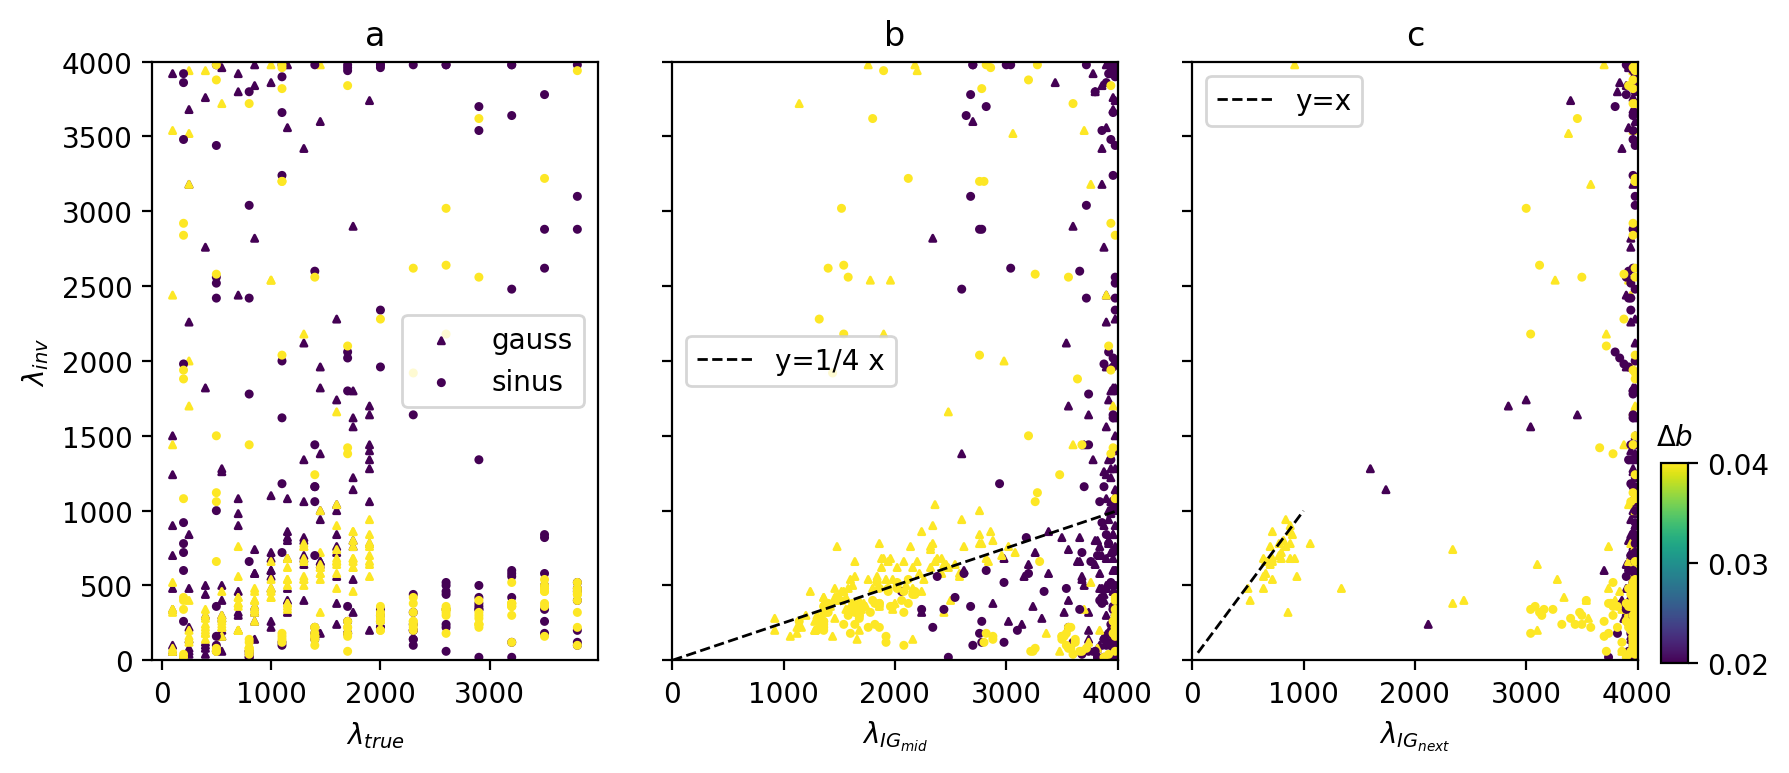

In [14]:
thresh_str = 'delta b'  #--> for filtering
thresh = 0.05

# Create a figure
fig, axs = plt.subplots(1, 4, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})


plt.rcParams.update({'font.size': 10})

ig_str = 'ig_next'
max_str = 'acf'

x1 = np.arange(50,1000)
axs[2].plot(x1,x1, label='y=x', color='k', linestyle='--', linewidth=1)


df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] < thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos =  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])
axs[2].yaxis. tick_right() 
axs[2].set_yticklabels([])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
#n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
#axs[0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', label= 'rect', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] < thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[2].set_xlabel('$\lambda_{IG_{next}}$')
axs[2].legend()

# set the title
axs[2].set_title('c')

# limits
axs[2].set_xlim(0,4000)
axs[2].set_ylim(0,4000)
axs[2].yaxis.tick_left() 
# y label
axs[0].set_ylabel('$\lambda_{inv}$')

# share of models not displayed
print('IG next: ', n_showed/n_total)
# share of lost positive models:
print('lost positive: ', n_notshowedpos)
# =============================================================================
# =============================================================================

ig_str = 'ig_here'
max_str = 'acf'

x1 = np.arange(0,4000)
axs[1].plot(x1,x1/4, label='y=1/4 x', color='k', linestyle='--', linewidth=1)

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] < thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<4000))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<2000))
#axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] < thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<3000) & (df_filter['n_max_'+max_str]<900))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[1].set_xlabel('$\lambda_{IG_{mid}}$')
axs[1].legend()

# set the title
axs[1].set_title('b')

# limits
axs[1].set_xlim(0,4000)
axs[1].set_ylim(0,4000)
axs[1].set_yticklabels([])

# share of models not displayed
print('IG mid: ', n_showed/n_total)
# =============================================================================
# =============================================================================

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] < thresh)]
n_total = len(df_filter)
n_showed = np.sum(df_filter['n_max_'+max_str]<4000)
cs = axs[0].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='^', label= 'gauss', c=df_filter['delta b'], s=5)

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum(df_filter['n_max_'+max_str]<2000)
#axp = axs[2].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] < thresh)]
n_total += len(df_filter)
n_showed += np.sum(df_filter['n_max_'+max_str]<4000)
axp = axs[0].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

axs[0].set_xlabel('$\lambda_{true}$')
#axs[2].legend()

# colorbar 
#adding colorbar and its position
import matplotlib.ticker as tkr
cbaxes = fig.add_axes([0.93, 0.155, 0.015, 0.25])  
cb = plt.colorbar(axp, cax = cbaxes, format=tkr.FormatStrFormatter('%.2g'))
cb.set_label('$\Delta b$', labelpad=-34, y=1.2, rotation=0)
axs[0].set_ylim(0,4000)
axs[0].set_title('a')
axs[0].legend()

axs[3].set_axis_off()


# share of models not displayed
print('true length: ', n_showed/n_total)

import matplotlib.pyplot as pyplt
pyplt.rcParams["figure.figsize"] = (18, 10)
# tight
plt.tight_layout()



IG next:  0.65
lost positive:  0
IG mid:  0.9990384615384615
true length:  0.9990384615384615


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_20611/2814497517.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


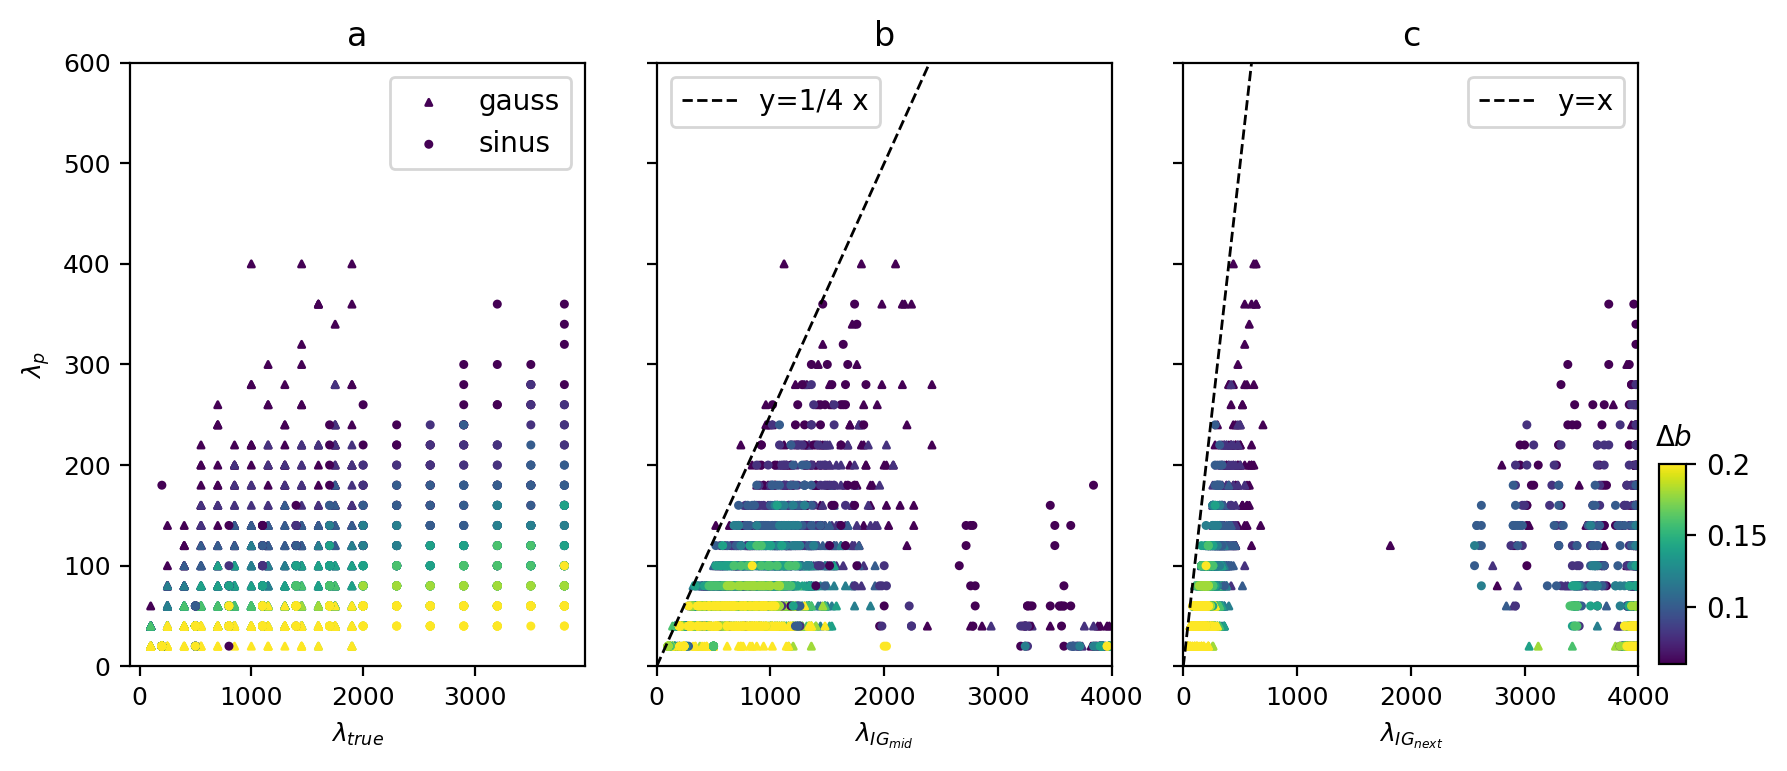

In [126]:
thresh_str = 'delta b'  #--> for filtering
thresh = 0.05

# Create a figure
fig, axs = plt.subplots(1, 4, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})


plt.rcParams.update({'font.size': 10})

ig_str = 'ig_next'
max_str = 'zval'

x1 = np.arange(0,1000)
axs[2].plot(x1,x1, label='y=x', color='k', linestyle='--', linewidth=1)


df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos =  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])
axs[2].yaxis. tick_right() 
axs[2].set_yticklabels([])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
#n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
#axs[0].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', label= 'rect', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<1000) & (df_filter['n_max_'+max_str]<900))
n_notshowedpos +=  np.sum((df_filter['n_max_'+ig_str]>1000) & (df_filter['n_max_'+max_str]>900) & (df_filter['max_'+ig_str]>0))
axs[2].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[2].set_xlabel('$\lambda_{IG_{next}}$')
axs[2].legend()

# set the title
axs[2].set_title('c')

# limits
axs[2].set_xlim(0,4000)
axs[2].set_ylim(0,600)
axs[2].yaxis.tick_left() 
# y label
axs[0].set_ylabel('$\lambda_{p}$')

# share of models not displayed
print('IG next: ', n_showed/n_total)
# share of lost positive models:
print('lost positive: ', n_notshowedpos)
# =============================================================================
# =============================================================================

ig_str = 'ig_here'
max_str = 'zval'

x1 = np.arange(0,4000)
axs[1].plot(x1,x1/4, label='y=1/4 x', color='k', linestyle='--', linewidth=1)

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<600))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='^', s=5, c=df_filter['delta b'])

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<2000))
#axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, color='goldenrod')

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum((df_filter['n_max_'+ig_str]<4000) & (df_filter['n_max_'+max_str]<600))
axs[1].scatter(df_filter['n_max_'+ig_str], df_filter['n_max_'+max_str], marker='o', s=5, c=df_filter['delta b'])

axs[1].set_xlabel('$\lambda_{IG_{mid}}$')
axs[1].legend()

# set the title
axs[1].set_title('b')

# limits
axs[1].set_xlim(0,4000)
axs[1].set_ylim(0,600)
axs[1].set_yticklabels([])

# share of models not displayed
print('IG mid: ', n_showed/n_total)
# =============================================================================
# =============================================================================

df_filter = df_eval_gauss
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total = len(df_filter)
n_showed = np.sum(df_filter['n_max_'+max_str]<600)
cs = axs[0].scatter(df_filter['length scale'], df_filter['n_max_zval'], marker='^', label= 'gauss', c=df_filter['delta b'], s=5)

#df_filter = df_eval_rectangle
#df_filter = df_filter[(df_filter[thresh_str] > thresh)]
#n_total += len(df_filter)
#n_showed += np.sum(df_filter['n_max_'+max_str]<2000)
#axp = axs[2].scatter(df_filter['length scale'], df_filter['n_max_acf'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

df_filter = df_eval_sinus
df_filter = df_filter[(df_filter[thresh_str] > thresh)]
n_total += len(df_filter)
n_showed += np.sum(df_filter['n_max_'+max_str]<600)
axp = axs[0].scatter(df_filter['length scale'], df_filter['n_max_zval'], marker='o', label= 'sinus', c=df_filter['delta b'], s=5)

axs[0].set_xlabel('$\lambda_{true}$')
#axs[2].legend()

# colorbar 
#adding colorbar and its position
import matplotlib.ticker as tkr
cbaxes = fig.add_axes([0.93, 0.155, 0.015, 0.25])  
cb = plt.colorbar(axp, cax = cbaxes, format=tkr.FormatStrFormatter('%.2g'))
cb.set_label('$\Delta b$', labelpad=-34, y=1.2, rotation=0)
axs[0].set_ylim(0,600)
axs[0].set_title('a')
axs[0].legend()

axs[3].set_axis_off()


# share of models not displayed
print('true length: ', n_showed/n_total)

import matplotlib.pyplot as pyplt
pyplt.rcParams["figure.figsize"] = (18, 10)
# tight
plt.tight_layout()



# Figure 4: synthetic test (resolution, resolution of changepoint analysis, step function)

In [7]:
import itertools as it

In [267]:
n_totals = [
    1000,
    2000,
    3000,
    4000,
    5000,
    7000,
    10000,
    15000,
    20000,
    25000,
    30000,
    35000,
    40000,
    50000,
]
delta_bs = np.arange(0, 1.025, 0.025)

all_permutations = [
    i
    for i in it.product(
        n_totals,
        delta_bs,
    )
]
all_permutations = np.array(all_permutations)

# parameter vectors to run through with cl_idx
cl_n_totals = all_permutations[:, 0].astype(int)
cl_delta_bs = all_permutations[:, 1]

def get_string_data(cl_idx):
    save_str = (
            "results/resolution/constant_idx/"
            "acf_mean" + str(cl_idx) + "_4.csv"
        )
    return save_str


def get_df():
    all_delta_bs = []
    all_n_totals = []
    all_acfs = []
    all_n_series_used = []

    for cl_idx in range(len(cl_n_totals)):
        save_str = get_string_data(cl_idx)
        try :
            acfs = np.genfromtxt('../'+save_str, delimiter=',')
        except :
            acfs = []
        try :
            n_series_used = np.genfromtxt('../'+save_str.replace("acf_mean", "n_used_mean"), delimiter=',')
        except :
            n_series_used = []

        all_delta_bs.extend([cl_delta_bs[cl_idx]]*len(acfs))
        all_n_totals.extend([cl_n_totals[cl_idx]]*len(acfs))
        all_acfs.extend(acfs)
        all_n_series_used.extend(n_series_used)

    print(all_n_totals)
    # make a dataframe
    df = pd.DataFrame({
        "acf": all_acfs,
        "delta b": all_delta_bs,
        "n_total": all_n_totals,
        "n_series_used": all_n_series_used,
    })
    return df

df = get_df()

df["p_val"] = pval_mac(np.array(df["acf"]), np.array(df["n_series_used"]),cutting="constant_idx")

# make contour plot od p-values

# make a grid of the parameters
delta_bs = np.unique(df['delta b'])
n_totals = np.unique(df['n_total'])

# for each parameter, get the quantiles of the p-values
p_val_grid = np.zeros((len(delta_bs), len(n_totals)))
for ii, delta_b in enumerate(delta_bs):
    for jj, n_total in enumerate(n_totals):
        p_val_grid[ii, jj] = np.quantile(1-df[(df['delta b'] == delta_b) & (df['n_total'] == n_total)]['p_val'], 0.05)

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


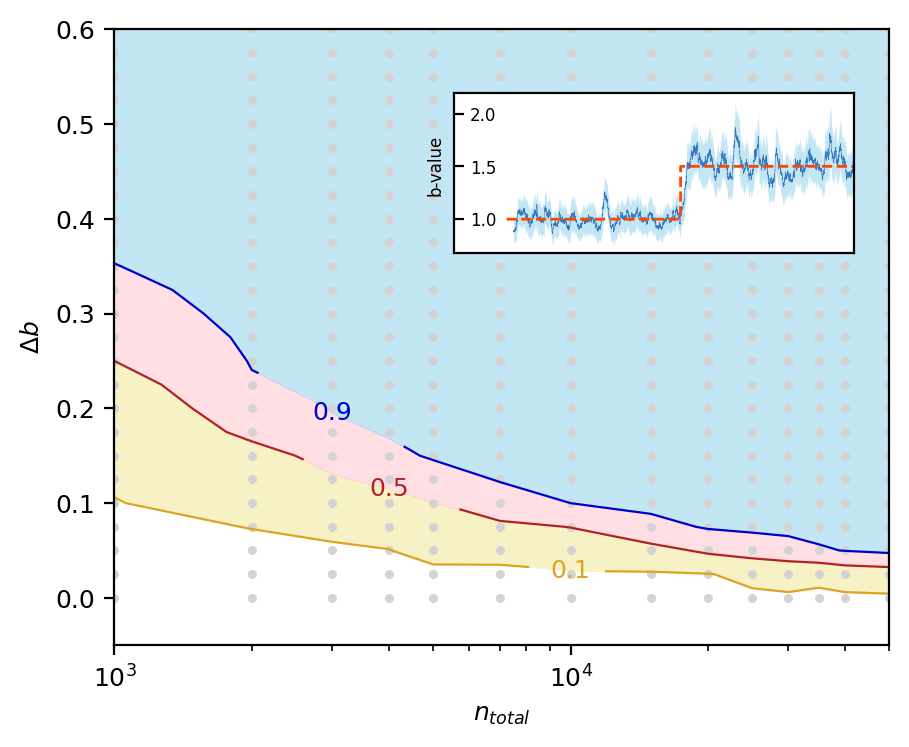

In [274]:
# Create a figure
plt.rcParams.update({'font.size': 9})

fig, ax1 = plt.subplots(figsize=(5, 4))
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.465, 0.6, 0.4, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

Contourrange = [0.1,0.5, 0.9]
cs = ax1.contour(n_totals, delta_bs, p_val_grid, levels=Contourrange, colors=['goldenrod','firebrick', 'mediumblue'], linewidths=0.8)

labels1 = plt.clabel(cs, inline=True, use_clabeltext=True, fontsize=9)
for l in labels1:
    l.set_rotation(0)

#Contourrange = [0.9]
#cs = ax1.contour(n_totals, delta_bs, p_val_grid, levels=Contourrange, colors=['mediumblue'], linestyles=['-'], linewidths=1)
#ax1.clabel(cs, fmt='%1.1f', manual=[(5000,0.4)])
Contourrange = [0.1,0.5, 0.9, 1]
cs = ax1.contourf(n_totals, delta_bs, p_val_grid, levels=Contourrange, colors=['khaki','pink','skyblue'], alpha=0.5)


# plot grid points
for ii, delta_b in enumerate(delta_bs):
    for jj, n_total in enumerate(n_totals):
        ax1.scatter(n_total, delta_b, color='lightgrey', s=5)

ax1.set_ylim(-0.05, 0.6)
ax1.set_xlim(1000, 50000)

ax1.set_xlabel('$n_{total}$')
ax1.set_ylabel('$\Delta b$')

# log x axis
ax1.set_xscale('log')

# ========
n = 10000
b = 1
delta_b = 0.5
mc = 0
delta_m = 0.1

mags, b_true = mags, b_true = simulate_step(n, b, delta_b, mc, delta_m)

dates = np.arange(len(mags))
b_time, idx_max, b_std = b_any_series(mags, dates, n_b = 200, mc=mc, delta_m=delta_m, return_std=True, overlap=1, method='tinti')

ax2.plot(dates[idx_max], b_time, label='b-value estimate', lw=0.2, color='#3778bf')
ax2.fill_between(dates[idx_max], b_time-1.96*b_std, b_time+1.96*b_std, alpha=0.5, label='95% confidence interval', lw=0, color='skyblue')
ax2.plot(dates, b_true, color='orangered', linestyle='--', label='true b-value', lw=1)
b_all = estimate_b(mags, mc=mc, delta_m=delta_m)
#ax.axhline(b_all, color='gray', linestyle='--')
ax2.set_ylabel('b-value', fontsize=6)
ax2.yaxis.set_label_coords(-0.025,0.55)
ax2.tick_params(axis="y",direction="in", pad=-15, labelsize=6)
ax2.set_xlim(-1500, 10000)
ax2.axes.get_xaxis().set_visible(False)
# ========

plt.savefig('../../Article_images/fig4.eps', format='eps')

# Figure 5: Parkfield: 1D

# Figure 6: Parkfield, 2D

## Distribution of the autocorrelation

In [8]:
from functions.core_functions import autocorrelation
from scipy.stats import shapiro


In [37]:
# autocorrelation, constant nm
 
n = 10000
n_sample = 20
mc = 0
delta_m = 0.1
b = 0.5

acfs_const = np.zeros(n)
n_series_used = np.zeros(n)
for ii in range(n):
      magnitudes = simulated_magnitudes_binned(n_sample*20, b, mc, delta_m)
      acfs_const[ii], n_series_used[ii] = autocorrelation(magnitudes, np.arange(len(magnitudes)), n_sample, mc, delta_m,n=1, b_method='tinti', transform=True, cutting='constant_idx', test=True)

mu_acf_const, std_acf_const = -1/np.mean(n_series_used), (np.mean(n_series_used)-2)/(np.mean(n_series_used)*np.sqrt(np.mean(n_series_used)))


/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_8871/2484571121.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acfs_const[ii], n_series_used[ii] = autocorrelation(magnitudes, np.arange(len(magnitudes)), n_sample, mc, delta_m,n=1, b_method='tinti', transform=True, cutting='constant_idx', test=True)


In [10]:
# autocorrelation, random nm

n = 10000
n_sample = 20
mc = 0
delta_m = 0.1
b = 0.5

acfs_rand= np.zeros(n)
n_series_used = np.zeros(n)
for ii in range(n):
      magnitudes = simulated_magnitudes_binned(n_sample*20, b, mc, delta_m)
      acfs_rand[ii], n_series_used[ii] = autocorrelation(magnitudes, np.arange(len(magnitudes)), n_sample, mc, delta_m,n=1, b_method='tinti', transform=True, cutting='random_idx', test=True)

mu_acf_rand, std_acf_rand = -1/np.mean(n_series_used), (np.mean(n_series_used)-2)/(np.mean(n_series_used)*np.sqrt(np.mean(n_series_used)))

/Users/aron/polybox/Projects/b_significant/functions/core_functions.py:452: UserWarning: nan encountered in b-series, check what is going on
  warnings.warn(
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_8871/1408756426.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  acfs_rand[ii], n_series_used[ii] = autocorrelation(magnitudes, np.arange(len(magnitudes)), n_sample, mc, delta_m,n=1, b_method='tinti', transform=True, cutting='random_idx', test=True)
/Users/aron/polybox/Projects/b_significant/env/lib/python3.11/site-packages/seismostats/analysis/estimate_beta.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  p = 1 + delta_m / np.average(magnitudes - mc, weights=weights)
/Users/aron/polybox/Projects/b_significant/env/lib/python3.11/site-packages/seismostats/analysis/estimate_be

In [82]:
# MAC, constant nm
n = 10000
n_sample = 25
mc = 0
delta_m = 0.1
b = 0.5

mac_const = np.zeros(n)
n_series_used = np.zeros(n)
for ii in range(n):
      magnitudes = simulated_magnitudes_binned(n_sample*20, b, mc, delta_m)
      acfs_loop, n_series_used_loop = autocorrelation(magnitudes, np.arange(len(magnitudes)), n_sample, mc, delta_m,n=100, b_method='tinti', transform=False, cutting='constant_idx')
      mac_const[ii] = np.mean(acfs_loop)
      n_series_used[ii] = np.mean(n_series_used_loop)

mu_mac_const, std_mac_const = -1/np.mean(n_series_used), 0.81* (np.mean(n_series_used)-2)/(np.mean(n_series_used)*np.sqrt(np.mean(n_series_used)))

In [83]:
scipy.stats.kstest(p,scipy.stats.uniform.cdf).pvalue

0.170814228531581

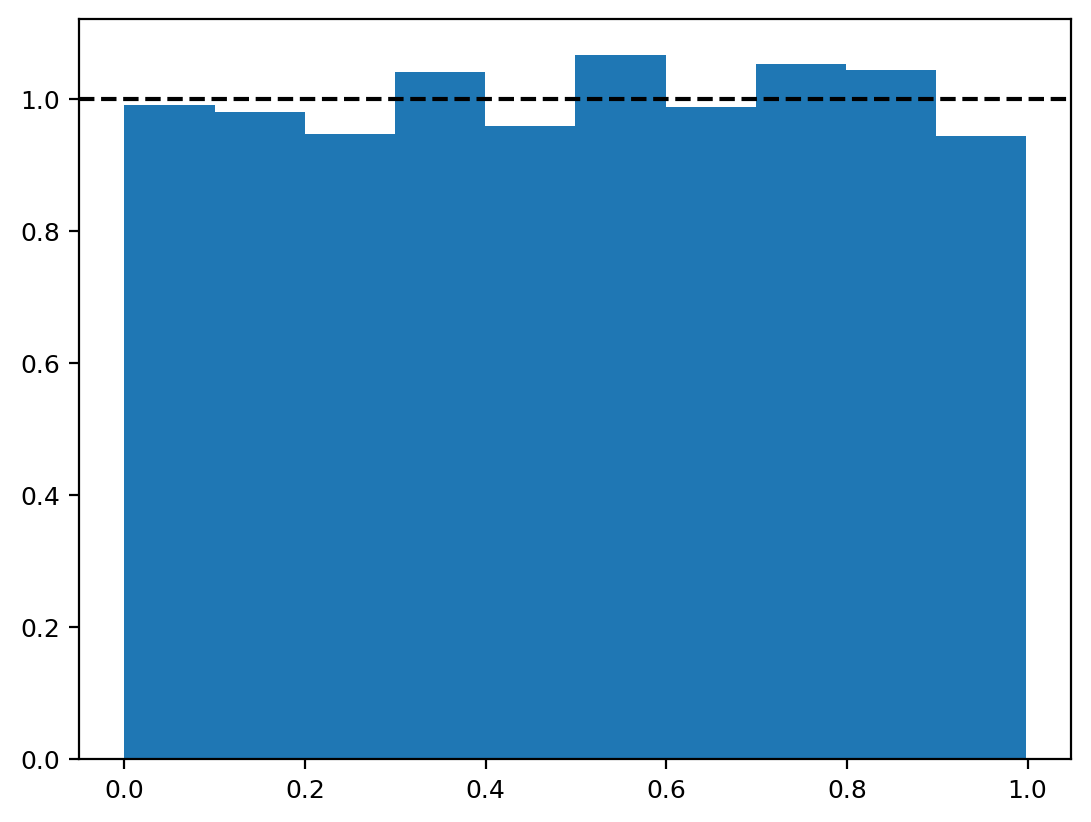

In [81]:
p = pval_mac(mac_const, n_series_used, cutting='constant_idx')
ax =plt.hist(p, density=True)

# plot line at 1
plt.axhline(1, color='k', linestyle='--')

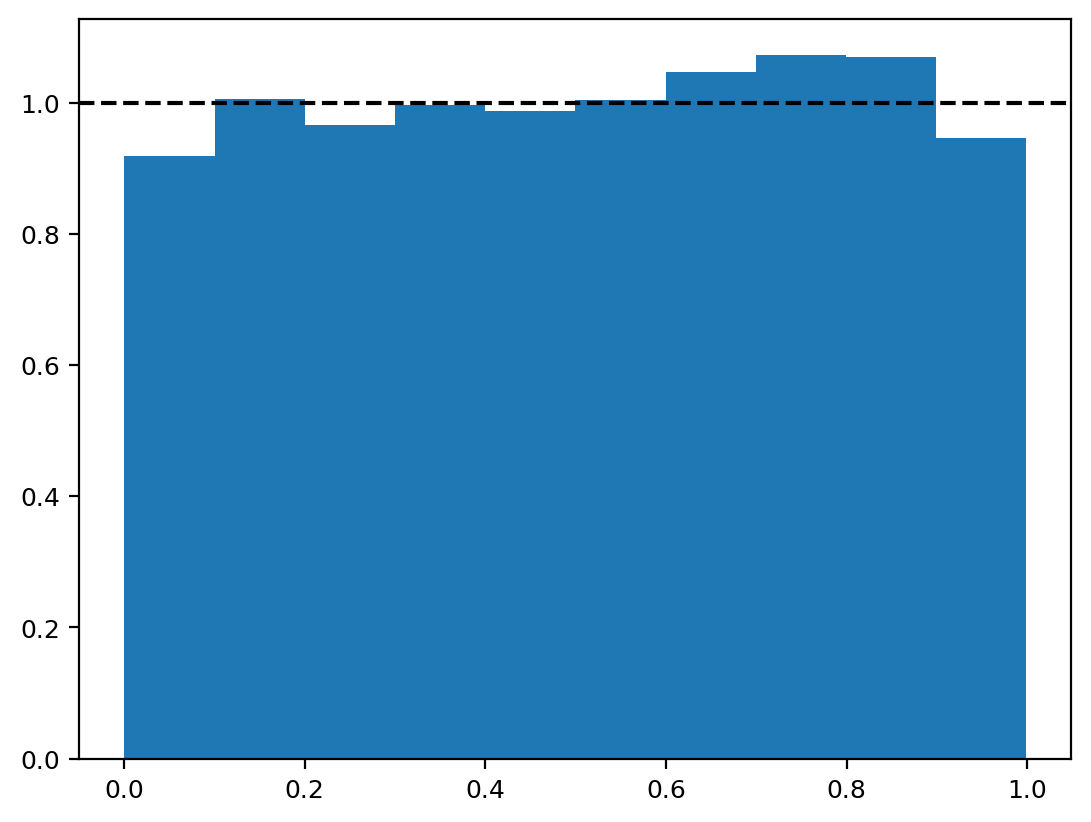

In [84]:
p = pval_mac(mac_const, n_series_used, cutting='constant_idx')
ax =plt.hist(p, density=True)

# plot line at 1
plt.axhline(1, color='k', linestyle='--')

In [72]:
p_ks = np.zeros(1000)
for ii in range(1000):
    p_ks[ii] = scipy.stats.kstest(scipy.stats.uniform.rvs(size=1000),scipy.stats.uniform.cdf).pvalue

(array([1.07441903, 0.93384084, 1.06437773, 0.99408863, 0.89367564,
        1.02421253, 1.00412993, 1.00412993, 0.96396473, 1.08446032]),
 array([7.40062029e-04, 1.00328768e-01, 1.99917473e-01, 2.99506179e-01,
        3.99094884e-01, 4.98683590e-01, 5.98272295e-01, 6.97861001e-01,
        7.97449707e-01, 8.97038412e-01, 9.96627118e-01]),
 <BarContainer object of 10 artists>)

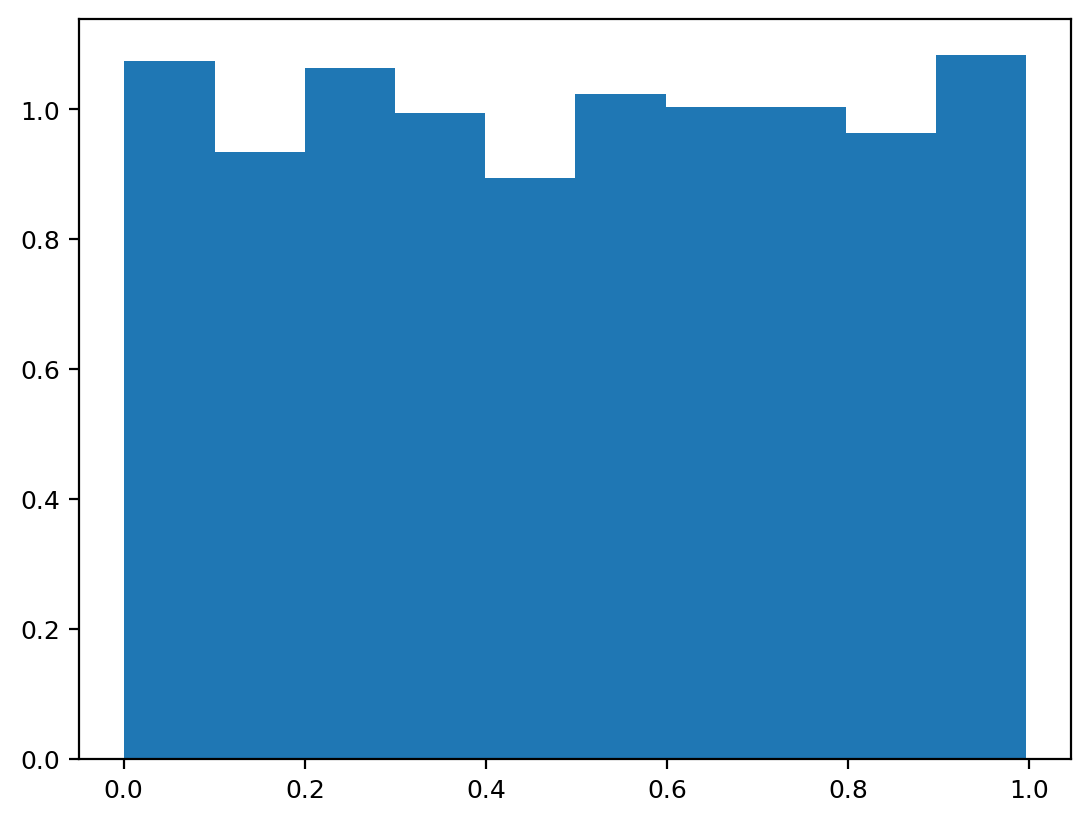

In [73]:
plt.hist(p_ks, density=True)

In [147]:
# MAC, random nm

n = 1000
n_sample = 20
mc = 0
delta_m = 0.1
b = 1

mac_rand = np.zeros(n)
n_series_used = np.zeros(n)
for ii in range(n):
      magnitudes = simulated_magnitudes_binned(n_sample*20, b, mc, delta_m)
      acfs_loop, n_series_used_loop = autocorrelation(magnitudes, np.arange(len(magnitudes)), n_sample, mc, delta_m,n=1000, nb_min=2, b_method='tinti', transform=True, cutting='random_idx')
      mac_rand[ii] = np.mean(acfs_loop)
      n_series_used[ii] = np.mean(n_series_used_loop)


mu_mac_rand, std_mac_rand = -1/np.mean(n_series_used), 0.45* (np.mean(n_series_used)-2)/(np.mean(n_series_used)*np.sqrt(np.mean(n_series_used)))

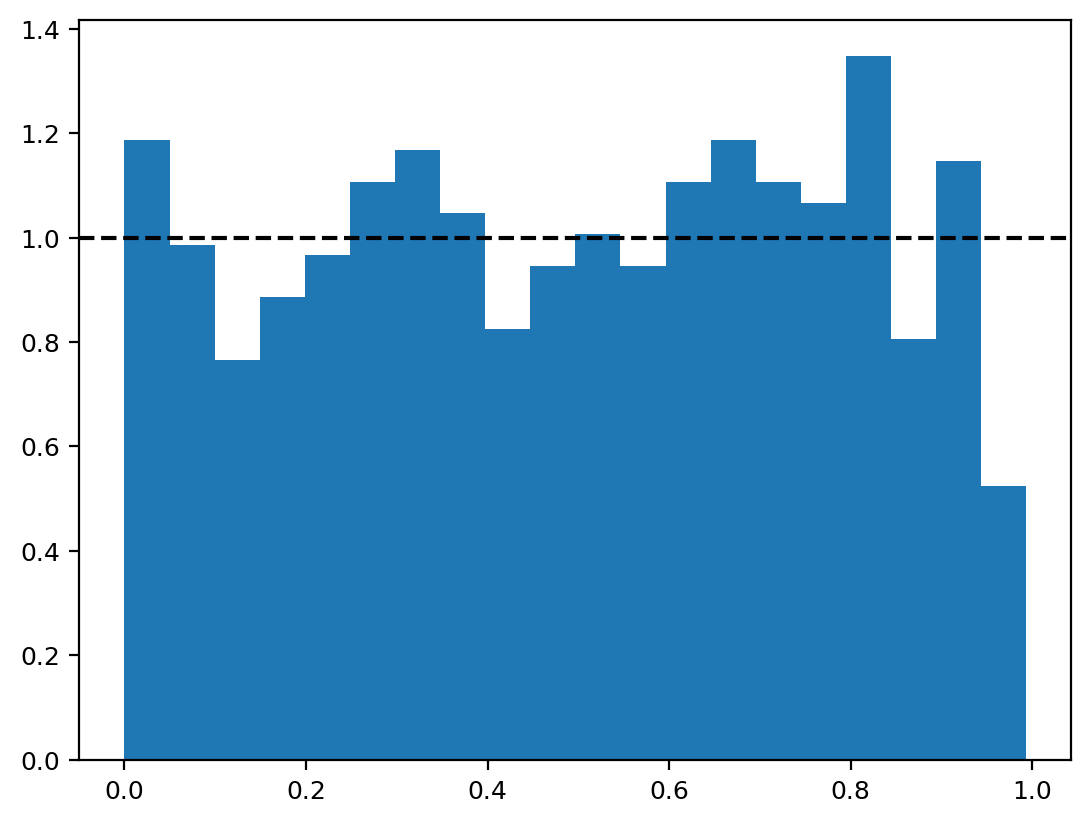

In [152]:
p = pval_mac(mac_rand, n_series_used, cutting='random_idx')
ax =plt.hist(p, density=True, bins=20)

# plot line at 1
plt.axhline(1, color='k', linestyle='--')

In [149]:
scipy.stats.kstest(p,scipy.stats.uniform.cdf).pvalue

0.17206889172009088

In [ ]:
p = pval_mac(mac_rand, n_series_used, cutting='random_idx')
ax =plt.hist(p, density=True)

# plot line at 1
plt.axhline(1, color='k', linestyle='--')

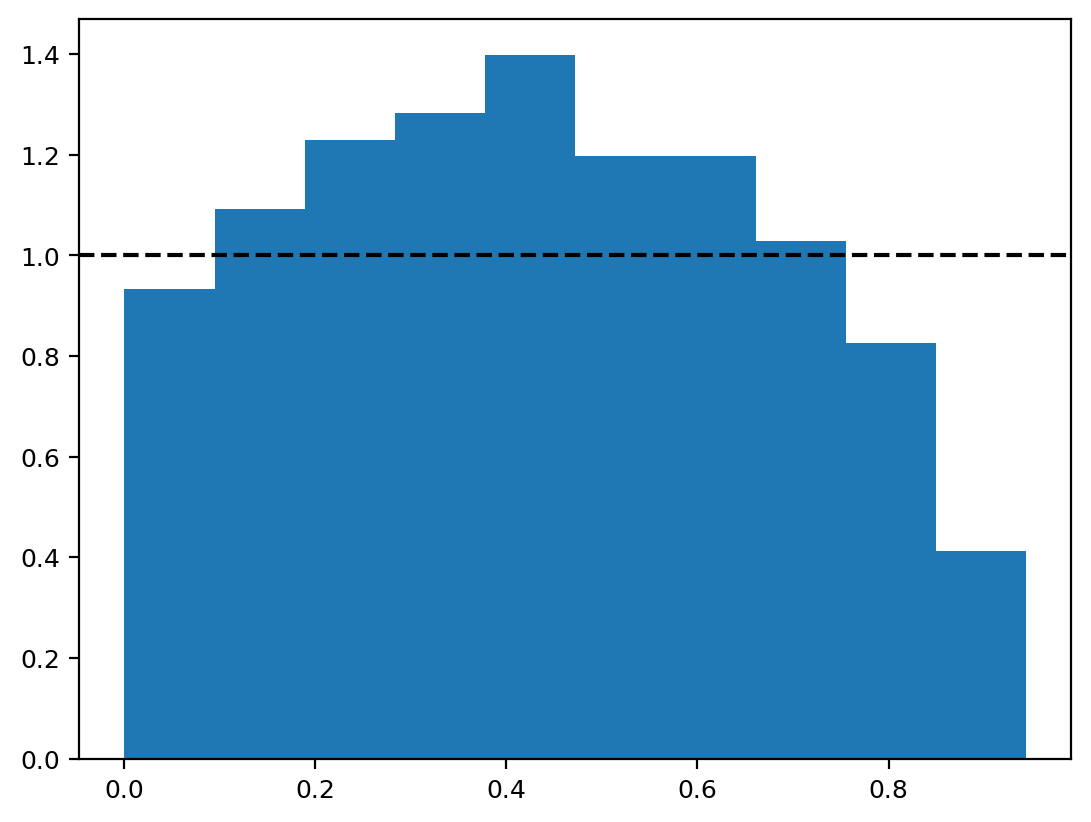

In [103]:
p = pval_mac(mac_rand, n_series_used, cutting='random_idx')
ax =plt.hist(p, density=True)

# plot line at 1
plt.axhline(1, color='k', linestyle='--')

In [104]:
scipy.stats.kstest(p,scipy.stats.uniform.cdf).pvalue

5.84063495302826e-17

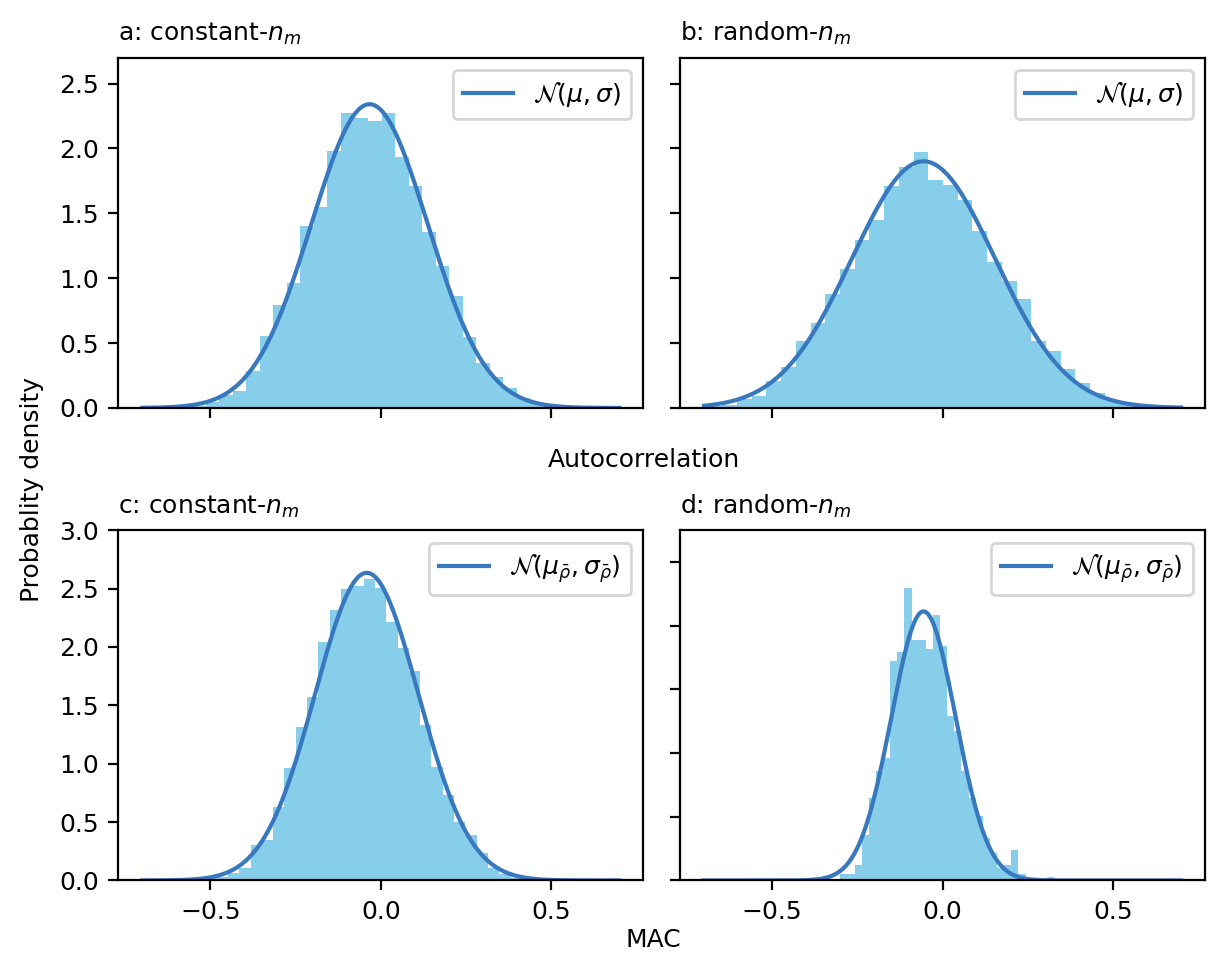

In [150]:
from scipy.stats import norm
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
# set fontsize
plt.rcParams.update({'font.size': 9})
# set fig size

ax[0,0].hist(acfs_const, density=True, bins=30, color='skyblue')
# plot normal distribution
x = np.linspace(-0.7, 0.7, 1000)
p = norm.pdf(x, mu_acf_const, std_acf_const)
ax[0,0].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
# set y limit
ax[0,0].set_ylim(0, 2.7)
ax[0,0].set_xlabel(' ')

ax[0,0].set_title('a: constant-$n_m$', fontsize=9, loc='left')
ax[0,0].set_xticklabels([])
ax[0,0].legend()

#================================================================
#================================================================

ax[1,0].hist(mac_const, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_mac_const, std_mac_const)
ax[1,0].plot(x, p, color = '#3778bf', linewidth=1.5, label=r'$\mathcal{N}(\mu_{\bar \rho}, \sigma_{\bar \rho})$')
# set y limit
ax[1,0].set_ylim(0, 3)

ax[1,0].set_xlabel(' ')
ax[1,0].set_title('c: constant-$n_m$', fontsize=9, loc='left')
ax[1,0].legend()

#================================================================
#================================================================
ax[0,1].hist(acfs_rand, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_acf_rand, std_acf_rand)
ax[0,1].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
# set y limit
ax[0,1].set_ylim(0, 2.7)

ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
ax[0,1].legend()

ax[0,1].set_title('b: random-$n_m$', fontsize=9, loc='left')

#================================================================
#================================================================

ax[1,1].hist(mac_rand, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_mac_rand, std_mac_rand)
ax[1,1].plot(x, p, color = '#3778bf', linewidth=1.5, label=r'$\mathcal{N}(\mu_{\bar \rho}, \sigma_{\bar \rho})$')
# set y limit
ax[1,1].set_ylim(0, 5.5)

ax[1,1].set_yticklabels([])
ax[1,1].set_title('d: random-$n_m$', fontsize=9, loc='left')
ax[1,1].legend()

#================================================================
#================================================================

fig.text(-0.01, 0.5, 'Probablity density', va='center', rotation='vertical')
fig.text(0.495, 0.05, 'MAC', va='center')
fig.text(0.43, 0.53, 'Autocorrelation', va='center')



plt.tight_layout()


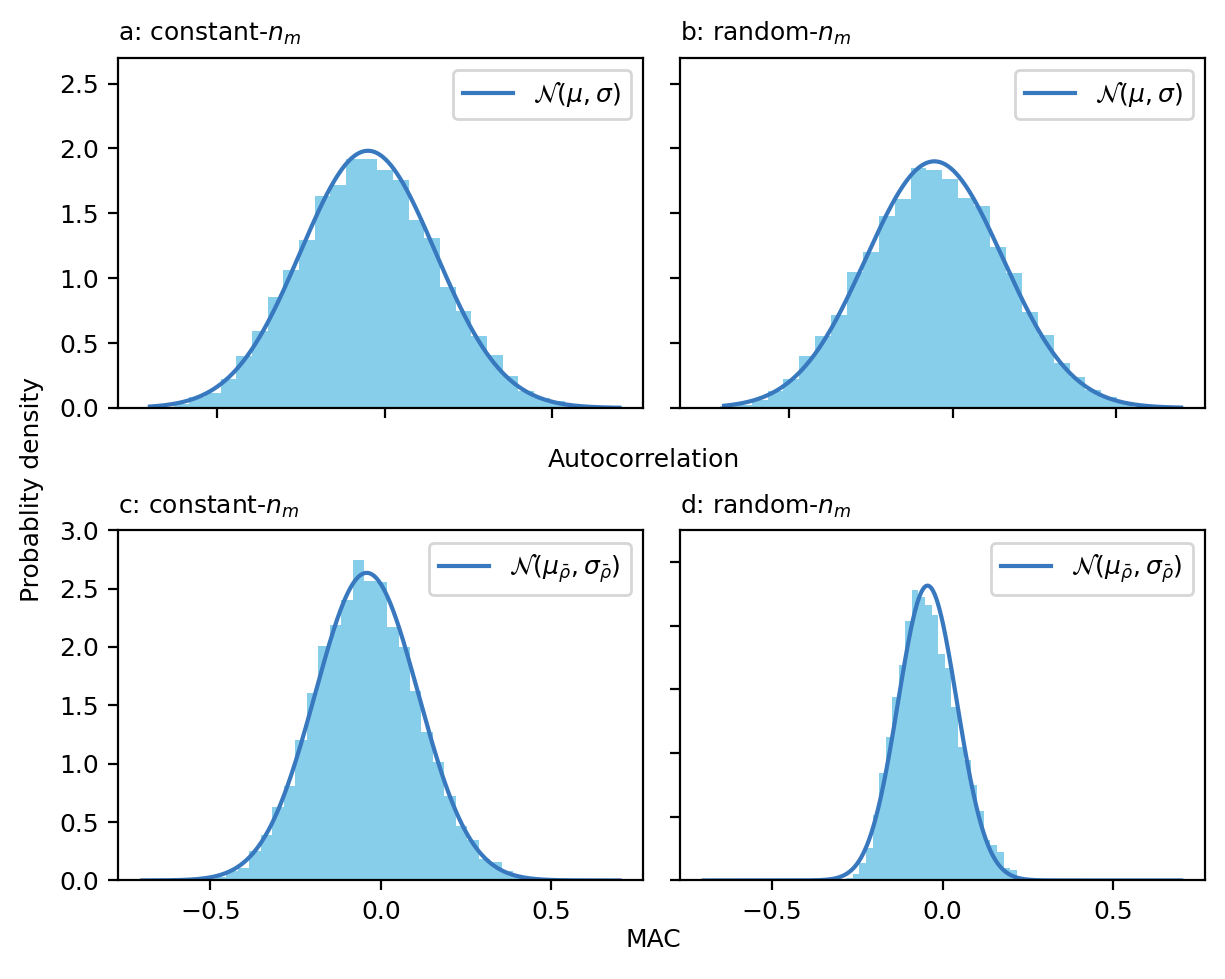

In [ ]:
from scipy.stats import norm
fig, ax = plt.subplots(2, 2, figsize=(6, 5))
# set fontsize
plt.rcParams.update({'font.size': 9})
# set fig size

ax[0,0].hist(acfs_const, density=True, bins=30, color='skyblue')
# plot normal distribution
x = np.linspace(-0.7, 0.7, 1000)
p = norm.pdf(x, mu_acf_const, std_acf_const)
ax[0,0].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
# set y limit
ax[0,0].set_ylim(0, 2.7)
ax[0,0].set_xlabel(' ')

ax[0,0].set_title('a: constant-$n_m$', fontsize=9, loc='left')
ax[0,0].set_xticklabels([])
ax[0,0].legend()

#================================================================
#================================================================

ax[1,0].hist(mac_const, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_mac_const, std_mac_const)
ax[1,0].plot(x, p, color = '#3778bf', linewidth=1.5, label=r'$\mathcal{N}(\mu_{\bar \rho}, \sigma_{\bar \rho})$')
# set y limit
ax[1,0].set_ylim(0, 3)

ax[1,0].set_xlabel(' ')
ax[1,0].set_title('c: constant-$n_m$', fontsize=9, loc='left')
ax[1,0].legend()

#================================================================
#================================================================
ax[0,1].hist(acfs_rand, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_acf_rand, std_acf_rand)
ax[0,1].plot(x, p, color = '#3778bf', linewidth=1.5, label='$\mathcal{N}(\mu, \sigma)$')
# set y limit
ax[0,1].set_ylim(0, 2.7)

ax[0,1].set_yticklabels([])
ax[0,1].set_xticklabels([])
ax[0,1].legend()

ax[0,1].set_title('b: random-$n_m$', fontsize=9, loc='left')

#================================================================
#================================================================

ax[1,1].hist(mac_rand, density=True, bins=30, color='skyblue')
# plot normal distribution
p = norm.pdf(x, mu_mac_rand, std_mac_rand)
ax[1,1].plot(x, p, color = '#3778bf', linewidth=1.5, label=r'$\mathcal{N}(\mu_{\bar \rho}, \sigma_{\bar \rho})$')
# set y limit
ax[1,1].set_ylim(0, 5.5)

ax[1,1].set_yticklabels([])
ax[1,1].set_title('d: random-$n_m$', fontsize=9, loc='left')
ax[1,1].legend()

#================================================================
#================================================================

fig.text(-0.01, 0.5, 'Probablity density', va='center', rotation='vertical')
fig.text(0.495, 0.05, 'MAC', va='center')
fig.text(0.43, 0.53, 'Autocorrelation', va='center')



plt.tight_layout()


# Resolution plot

In [26]:
n_series = [15, 20, 25, 30, 40, 50, 70, 100, 150, 200, 250, 300]
n_totals = [5000, 10000, 15000, 20000, 25000, 30000, 35000]
bs = [0.7, 1.0, 1.3]

all_permutations = [
    i
    for i in it.product(
        n_series,
        n_totals,
        bs,
    )
]
all_permutations = np.array(all_permutations)

# parameter vectors to run through with cl_idx
cl_n_series = all_permutations[:, 0].astype(int)
cl_n_totals = all_permutations[:, 1].astype(int)
cl_bs = all_permutations[:, 2]

def get_string_data(cutting, transform, cl_idx):
    if cutting == "constant_idx":
        save_str = (
            "results/distributions/cutting_" + str(cutting) + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    else:
        save_str = (
            "results/distributions/cutting_"
            + str(cutting)
            + "/transform_"
            + str(transform)
            + "/"
            "acf_mean_" + str(cl_idx) + ".csv"
        )
    return save_str


def get_df(cutting, transform):
    all_acfs = []
    all_n_series = []
    all_n_series_used = []
    all_bs = []
    all_n_totals = []

    for cl_idx in range(len(cl_n_series)):

        save_str = get_string_data(cutting, transform, cl_idx)

        try :
            acfs = np.genfromtxt('../'+save_str, delimiter=',')
        except :
            acfs = []
        try :
            n_series_used = np.genfromtxt('../'+save_str.replace("acf_mean", "n_used_mean"), delimiter=',')
        except :
            n_series_used = []
        all_acfs.extend(acfs)
        all_n_series_used.extend(n_series_used)
        all_n_series.extend([cl_n_series[cl_idx]]*len(acfs))
        all_bs.extend([cl_bs[cl_idx]]*len(acfs))
        all_n_totals.extend([cl_n_totals[cl_idx]]*len(acfs))

    # make a dataframe
    df = pd.DataFrame({
        "acf": all_acfs,
        "n_series": all_n_series,
        "n_series_used": all_n_series_used,
        "b": all_bs,
        "n_total": all_n_totals,
    })
    return df

In [27]:
cutting = "constant_idx"
df_const = get_df(cutting, transform)

cutting = "random_idx"
transform = True
df_rand = get_df(cutting, transform)

In [41]:
from scipy.stats import bootstrap

acf_std = []
acf_error= []

for n_s in n_series:
    # filter the dataframe for n_s
    df_n_s = df_const[df_const['n_series'] == n_s]
    acf_std.append(df_n_s['acf'].std())
    acf_error.append(bootstrap((df_n_s['acf'].values,), np.std, confidence_level=0.99).standard_error)

# theoretical std
sigma_const = 0.81/np.sqrt(n_series)

In [42]:
from scipy.stats import bootstrap

acf_std_rand = []
acf_error_rand= []

for n_s in n_series:
    # filter the dataframe for n_s
    df_n_s = df_rand[df_rand['n_series'] == n_s]
    acf_std_rand.append(df_n_s['acf'].std())
    acf_error_rand.append(bootstrap((df_n_s['acf'].values,), np.std, confidence_level=0.99).standard_error)

# theoretical std
sigma_rand = 0.45/np.sqrt(n_series)

In [113]:
acf_mean_const = []
acf_mean_rand = []

for n_s in n_series:
    # filter the dataframe for n_s
    df_n_s = df_const[df_const['n_series'] == n_s]
    acf_mean_const.append(df_n_s['acf'].mean())
    df_n_s = df_rand[df_rand['n_series'] == n_s]
    acf_mean_rand.append(df_n_s['acf'].mean())

# theoretical std
mean_th = -1/n_series


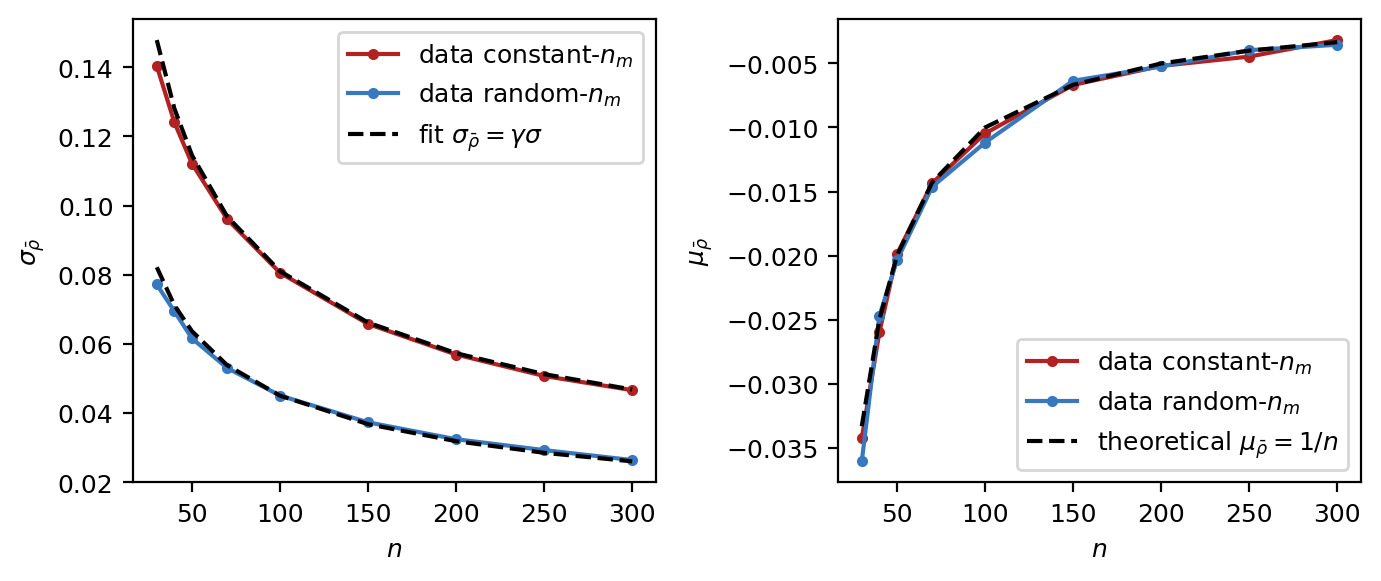

In [134]:
# Create a figure
plt.rcParams.update({'font.size': 9})

fig, axs = plt.subplots(1, 2, figsize=(7, 3))

n_series= np.array(n_series)
sigma_const = np.array(sigma_const)
sigma_rand = np.array(sigma_rand)
acf_std = np.array(acf_std)
acf_std_rand = np.array(acf_std_rand)
acf_error = np.array(acf_error)
acf_error_rand = np.array(acf_error_rand)
acf_mean_const = np.array(acf_mean_const)
acf_mean_rand = np.array(acf_mean_rand)
idx =n_series > 25

axs[0].plot(n_series[idx], acf_std[idx], 'firebrick', label='data constant-$n_m$', marker='o', markersize=3)

axs[0].plot(n_series[idx], acf_std_rand[idx], '#3778bf',label='data random-$n_m$', marker='o', markersize=3)
axs[0].plot(n_series[idx], sigma_rand[idx], 'k--')
axs[0].plot(n_series[idx], sigma_const[idx], 'k--', label=r'fit $\sigma_{\bar\rho} = \gamma  \sigma$')


axs[0].legend()
axs[0].set_xlabel('$n$')
axs[0].set_ylabel(r'$\sigma_{\bar \rho}$')


axs[1].plot(n_series[idx], acf_mean_const[idx], 'firebrick', label='data constant-$n_m$', marker='o', markersize=3)
axs[1].plot(n_series[idx], acf_mean_rand[idx], '#3778bf', label='data random-$n_m$', marker='o', markersize=3)
axs[1].plot(n_series[idx], mean_th[idx], 'k--', label=r'theoretical $\mu_{\bar\rho} = 1/n $')

axs[1].legend()
axs[1].set_xlabel('$n$')
axs[1].set_ylabel(r'$\mu_{\bar \rho}$')

plt.tight_layout()